# Import all the required libraries and packages

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import time

import re  
import nltk

from nltk.corpus import stopwords
from nltk.corpus import RegexpTokenizer as regextoken
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import pickle

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

from sklearn.decomposition import PCA
from __future__ import print_function

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [2]:
os.getcwd()

'/Users/z066910/Desktop/PHDHackathon V1'

# Import and Explore data

In [25]:
dataset=pd.read_csv('GrievancesData_Train.csv')

In [26]:
dataset.dtypes

GrievanceID             object
BankID                  object
State                   object
DateOfGrievance         object
Grievance_Category      object
GrievanceDescription    object
LineOfBusiness          object
ResolutionComments      object
Disputed                object
DateOfResolution        object
dtype: object

In [27]:
dataset.describe()

GrievanceID    BankID   State DateOfGrievance  \
count        53680     53680   53559           53680   
unique       53680        86      59            1222   
top      GID462347  Bank5286  State9      2014-01-19   
freq             1      5623    8110             172   

                              Grievance_Category  \
count                                      53680   
unique                                        67   
top     Loan servicing, payments, escrow account   
freq                                        8455   

                                     GrievanceDescription LineOfBusiness  \
count                                               53680          53680   
unique                                              46662              4   
top      I was shocked when I reviewed my credit repor...    Credit card   
freq                                                    8          21638   

             ResolutionComments Disputed DateOfResolution  
count                     53680    53680            53680  
unique                        4        2             1248  
top     Closed with explanation       No       2013-10-01  
freq                      41546    41895              142

In [28]:
dataset.head(1)

GrievanceID    BankID    State DateOfGrievance  \
0   GID512411  Bank5279  State31      2016-01-19   

             Grievance_Category  \
0  Settlement process and costs   

                                GrievanceDescription LineOfBusiness  \
0   Bank5279 Research dpt. \nXXXX XXXX XXXX XXXX,...       Mortgage   

        ResolutionComments Disputed DateOfResolution  
0  Closed with explanation       No       2016-01-30

In [29]:
dataset.tail(1)

GrievanceID    BankID    State DateOfGrievance  \
53679   GID502400  Bank5338  State59      2015-08-24   

                   Grievance_Category  \
53679  Trouble during payment process   

                                    GrievanceDescription LineOfBusiness  \
53679   Dear Bank5338, Your letter dated XXXX XXXX wa...       Mortgage   

            ResolutionComments Disputed DateOfResolution  
53679  Closed with explanation       No       2015-09-09

In [30]:
print(dataset.columns)

Index([u'GrievanceID', u'BankID', u'State', u'DateOfGrievance',
       u'Grievance_Category', u'GrievanceDescription', u'LineOfBusiness',
       u'ResolutionComments', u'Disputed', u'DateOfResolution'],
      dtype='object')


In [31]:
#Check for the shape (no.of rows,columns) of the data
print(dataset.shape)

(53680, 10)


In [32]:
#Check for missing values in the data
print(dataset.isnull().sum())

GrievanceID               0
BankID                    0
State                   121
DateOfGrievance           0
Grievance_Category        0
GrievanceDescription      0
LineOfBusiness            0
ResolutionComments        0
Disputed                  0
DateOfResolution          0
dtype: int64


In [13]:
#Frequency Count
#dataset.groupby('BankID').size()
#dataset.groupby('GrievanceID').size()
#dataset.groupby('State').size()
#dataset.groupby('DateOfGrievance').size()
#dataset.groupby('GrievanceDescription').size()

#No.o unique text 46662

dataset.groupby('LineOfBusiness').size()

#dataset.groupby('ResolutionComments').size()
#Closed with explanation -> # texts 41546

#dataset.groupby('Disputed').size()
# Disputed = Yes -> # grievances 11785

#dataset.groupby('DateOfResolution').size()

LineOfBusiness
Consumer Loan     5512
Credit card      21638
Mortgage         21268
Student loan      5262
dtype: int64

In [33]:
#Remove duplicate records

#Deleting if records are repeting just with different grievance id
df=dataset.drop_duplicates(['BankID','State','DateOfGrievance','Grievance_Category','GrievanceDescription','LineOfBusiness','ResolutionComments','Disputed','DateOfResolution'],keep='first')

In [15]:
df.shape

(48496, 10)

In [34]:
#Checking records for discrepency
df.loc[(df['BankID'] == 'Bank5397') & (df['State'] == 'State22') & (df['GrievanceID'].isin (['GID414513','GID414630']))]

GrievanceID    BankID    State DateOfGrievance Grievance_Category  \
27283   GID414513  Bank5397  State22      2013-06-10   Billing disputes   

                                    GrievanceDescription LineOfBusiness  \
27283   I was shocked when I reviewed my credit repor...    Credit card   

            ResolutionComments Disputed DateOfResolution  
27283  Closed with explanation       No       2013-06-21

In [37]:
#Reset the index of the deduped data
df.reset_index()
df1=df.reset_index(drop=True)
df1.head(1)

GrievanceID    BankID    State DateOfGrievance  \
0   GID512411  Bank5279  State31      2016-01-19   

             Grievance_Category  \
0  Settlement process and costs   

                                GrievanceDescription LineOfBusiness  \
0   Bank5279 Research dpt. \nXXXX XXXX XXXX XXXX,...       Mortgage   

        ResolutionComments Disputed DateOfResolution  
0  Closed with explanation       No       2016-01-30

In [38]:
#Data for text mining
datatxt= df1[['GrievanceID','GrievanceDescription']]

In [19]:
datatxt.shape

(48496, 2)

# Part 1

# Train Data preparation using Greivance data

# Grievance Description -Text Mining

### 1)Develop unique words/phrases for identification of a grievance as UFDP. Create features explaining UFDP (Y/N). Also create other additional features based on domain understanding


# Cleaning text

In [86]:
#Define function to preprocess text
def text_to_words( text ):
    start = time.time()
    #letters_only = re.sub("[^a-zA-Z0-9$%!]", " ", text) 
    letters_only = re.sub("[^a-zA-Z]", " ", text) 
    words = letters_only.lower().split()
    stop_words = stopwords.words('english')
    #Extending the stop words list by adding data specific unwanted words to the list
    stop_words.extend(['xx','xxx','xxxx','bank america','bank','citi','ocwen','ocwens','gl','rp','fitbit','cement','mls','lfs','reo','hhf','be','di','pt','ax','sp','america','american','bankamericard','americans','americas','aaa','aa','aafes','us','usa','usbank'])
    stops = set(stop_words)  
    lm=WordNetLemmatizer()
    meaningful_words = [lm.lemmatize(w,pos='v') for w in words if not w in stops]
    
    #Convert plurals to singular
    #postg=pos_tag(meaningful_words)
    #newwords=[w[0].rstrip("s") if w[1]=='NNS' else w[0] for w in postg]
    
    #ps = PorterStemmer()
    #meaningful_words = [ps.stem(w) for w in words if not w in stops]
    
    return( " ".join( meaningful_words )) 
    #return( " ".join( newwords )) 
    
    end = time.time()
    print("Time elapsed for execution = ", end - start)

In [87]:
#No.of texts to process
num_texts = datatxt["GrievanceDescription"].size
print(num_texts)

48496


In [88]:
#Define function to clean text
def cleantxt(IP,rec):
    #Initialize an empty list to hold the clean texts
    clean_reviews = []
    start = time.time()
    #Loop over each text
    for i in range(0, rec):
        #Call function for each text, and add the result to the list of clean reviews
        clean_reviews.append(text_to_words(IP["GrievanceDescription"][i]))
    
    end = time.time()
    print("Time elapsed for execution = ", end - start)
    return clean_reviews                          

In [89]:
#Call clean text function to create corpus of cleaned text, all data (train)
clean_reviews=cleantxt(datatxt,rec=num_texts)
clean_reviews

Time elapsed for execution =  62.0309178829


[u'research dpt ca name customer loan refinance home new loan fund include copy statement hud close show exactly pay receive check amount date escrow however escrow statement enclose show addition add payment total would like know happen ballance escrow account leave escrow call speak personel facility nobody give name feel obligate forward attorney general department house urban development expect hear representative',
 u'mortgage never miss payment refinance citizens mortgage obtain loan completely renovate home home build current mortgage house single family ocean view car garage additional park spot late move start refinance process citizens lower monthly payment close would longer need pmi insurance provide citizens every document ask asap sign allow income tax release pay appraisial home occur apprasal come signifigantly market value raise complaints appraisal loan originator citizens agree way value would file complaint loan fine even though appraisal artificially low tell would

In [90]:
# Define a function to get the TF matrix
#Create bag of word model/tockenization/Creating Sparse metrics
def TF(IP,OPCSV,ngram,MAXFEATURES):
    start = time.time()
    from sklearn.feature_extraction.text import CountVectorizer

    #tf_vectorizer = CountVectorizer(ngram_range=(1,1),max_features=10)
    tf_vectorizer = CountVectorizer(ngram_range=(ngram,ngram),max_features=MAXFEATURES) #we can specify min_df=0.1 if required here
    tf = tf_vectorizer.fit_transform(IP)

    #print(tf)
    # Array mapping from feature integer indices to feature name
    OPDF=pd.DataFrame(tf.toarray(), columns= tf_vectorizer.get_feature_names()) 
    #48496 rows × 36742 columns

    OPDF.to_csv(OPCSV)
    return OPDF

    end = time.time()
    print("Time elapsed for execution = ", end - start)

In [91]:
#Call TF function with IP, OP , maxfeatures and ngram parameters on all data (train)
#Try uni, bi and trigrams
TFdata=TF(clean_reviews,'Temp.csv',ngram=1,MAXFEATURES=500)

In [195]:
#TFdata.sum().to_csv("TFMF5000NGM2.csv")

In [92]:
#Compute TF-ITF Matrix

def TFIDF(IP,OPCSV,ngram,MAXFEATURES):
    start = time.time()
    from sklearn.feature_extraction.text import TfidfVectorizer

    tfidf_vectorizer = TfidfVectorizer(ngram_range=(ngram,ngram),max_features=MAXFEATURES) # we can add stop_words='english', if needed here also
    tfidf = tfidf_vectorizer.fit_transform(IP)  
    #type(tfidf)
    #print(tfidf)

    # Array mapping from feature integer indices to feature name
    OPDF=pd.DataFrame(tfidf.toarray(), columns= tfidf_vectorizer.get_feature_names())

    OPDF.to_csv(OPCSV)
    return OPDF

    end = time.time()
    print("Time elapsed for execution = ", end - start)

In [95]:
#Call TFIDF function with IP, OP , maxfeatures and ngram parameters on all data (train)
#Try uni, bi and trigrams
TFIDFdata=TFIDF(clean_reviews,'TFIDFData500_1.csv',ngram=1,MAXFEATURES=1000)

In [96]:
TFIDFdata.shape

(48496, 1000)

In [200]:
#TFIDFdata.sum().to_csv("TFIDFMF5000NGM3.csv")
#TFIDFdata.sum().to_csv("TFIDFMF5000NGM2.csv")

# Wordcloud

In [52]:
#Define the function for creating wordcloud

def wordcloud(IP,OP):
    start = time.time()
    import wordcloud
    from wordcloud import WordCloud
    #For word cloud converting the clean_reviews list to string
    Str1 = ''.join(str(w) for w in IP)
    #Str
    wordcloud = WordCloud(width=1300, height=600).generate(Str1)
    # Open a plot of the generated image.

    import matplotlib.pyplot as plt
    #%matplotlib inline
    plt.figure( figsize=(20,10), facecolor='k')

    plt.imshow(wordcloud,interpolation='bilinear')
    # interpolation="bilinear" in the plt.imshow() is to make the displayed image appear more smoothly
    plt.axis("off")
    #plt.tight_layout(pad=0)
    #plt.show()

    #Replace last two commented line with the below code, to save the flie the working directory
    plt.savefig(OP, facecolor='k', bbox_inches='tight')
    
    end = time.time()
    print("Time elapsed for execution = ", end - start)

Time elapsed for execution =  35.8658680916


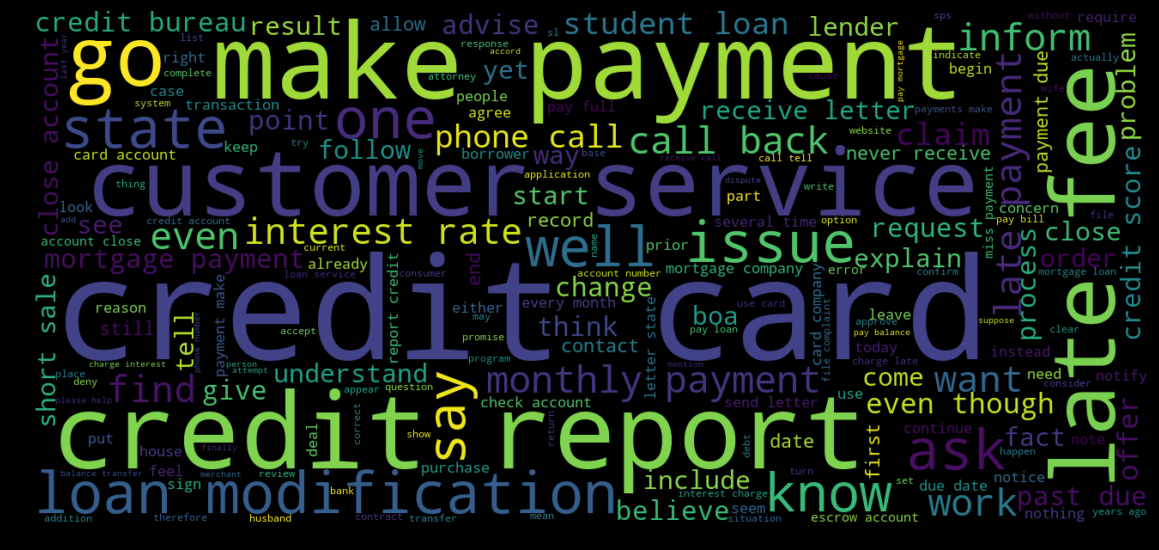

In [53]:
#Word cloud on all data (train)

#call function. Provide the IP and OP paremeters
wordcloud(clean_reviews,'wordcloudalldata.png')

# Feature Scaling


In [54]:
def Feature_scaling(IP):
    start = time.time()
    from sklearn.preprocessing import StandardScaler
    sc = StandardScaler()
    data_scaled = sc.fit_transform(IP)
    OPDF=pd.DataFrame(data_scaled,  columns= IP.columns.values.tolist())
    return OPDF
    end = time.time()
    print("Time elapsed for execution = ", end - start)

In [55]:
#Call the feature scaling function on TFIDF of all data (train)
TFIDFdata_Scaled=Feature_scaling(TFIDFdata)
#print TFIDFdata_Scaled.std()
#print TFIDFdata_Scaled.mean()

# PCA

In [56]:
#Perform PCA for dimensionality reduction
#Define function to perform PCA
def PCAfn(IP,OPCSV,n,topn):
    start = time.time()

    from sklearn.decomposition import PCA
    
    pca = PCA(n_components=n)
    PCAOP = pca.fit_transform(IP)
    explained_variance = pca.explained_variance_ratio_

    #output variance explained by the pricipal components along with feature matrix
    print ("Variance explained by all the principal components = ", sum(explained_variance))

    print ("Top to Principal components", explained_variance[:topn])
    print ("Variance explained by top", topn, "principal components = ", sum(explained_variance[:topn]))
    
    #print pd.DataFrame(pca.components_,columns=TFIDFdata.columns)
    
    #Export Principal components to csv
    pd.DataFrame(pca.components_,columns=IP.columns).to_csv(OPCSV)
    
    #Creating column names for principal components
    Columns = ['PC_{}'.format(i+1) for i in range(n)]
    
    #Creating dataframe for the PCA results 
    PCADF=pd.DataFrame(PCAOP, columns=Columns)
    
    end = time.time()
    print("Time elapsed for execution = ", end - start)
    
    return PCADF

In [57]:
#Call the PCA function to generate the desired no.of principal components of all data (train)

#Input the parameter values as required
#IP data can be original or scaled
#name on the OP csv
#no.of principal components
#topn -> to specify the top principal componets to compute the total explained variance if required

TFIDF_PCAOP=PCAfn(TFIDFdata,"TFIDFPCA25_500.csv",n=25,topn=10)

Variance explained by all the principal components =  0.24145649562481475
Top to Principal components [0.03204003 0.01940122 0.01683126 0.01509534 0.01367861 0.01119002
 0.01071746 0.01040671 0.00943823 0.00888682]
Variance explained by top 10 principal components =  0.14768570339077963
Time elapsed for execution =  1.04927706718


# Clustering to label grievance as UFDP or not using TF-IDF

In [58]:
#Define a function to get elbow plot
# Using the elbow method to find the optimal number of clusters

def Elbowclusterselect(IP,k):
    start = time.time()
    wcss = []
    for i in range(1, k):
        kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter=100, n_init=10 ,random_state = 0)
        kmeans.fit(IP)
        wcss.append(kmeans.inertia_)
    plt.plot([1,2,3], wcss)
    plt.title('The Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

    end = time.time()
    print("Time elapsed for execution = ", end - start)

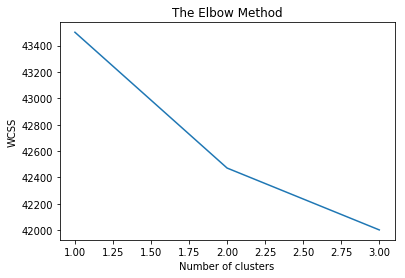

Time elapsed for execution =  25.229008913


In [59]:
#IP data -> either use original(scaled), or PCA
#Call the elbow plot function to identify the no.of optimal clusters on all data (train)
Elbowclusterselect(TFIDFdata,k=4)

In [60]:
#Define function to build the cluster solution , visualize the clusters and list top terms per cluster
def Clusters(IP,ModelOP,k):
    start = time.time()
    from sklearn.decomposition import PCA
    clustermodel = KMeans(n_clusters = k, init = 'k-means++', max_iter=100, n_init=10 ,random_state = 0)
    clustermodel_fit=clustermodel.fit(IP)
    cluster_lbl=clustermodel.fit_predict(IP)
    
    # save the model to disk
    filename = ModelOP
    pickle.dump(clustermodel_fit, open(filename, 'wb'))

    clusterids=pd.DataFrame(cluster_lbl)
    clusterids.columns = ['Clusterid']

    #Join the cluster ids and the raw IP data
    frames = [clusterids, TFIDFdata]
    clusterresults = pd.concat(frames,axis=1)
    
    #Visualize the clusters
    pca_2 = PCA(2) # return 2 first canonical variables
    plot_columns = pca_2.fit_transform(IP) # fit CA to the train dataset
    plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=cluster_lbl,) # plot 1st canonical variable on x axis, 2nd on y-axis
    plt.xlabel('Canonical variable 1')
    plt.ylabel('Canonical variable 2')
    plt.title('Scatterplot of Canonical Variables for 2 Clusters')
    plt.figure( figsize=(300,100), facecolor='k')
    plt.show() 
    
    #Top terms per clusters
    terms=IP.columns.values.tolist()
    
    print("Top 50 terms per cluster:")
    print()
    #Sort cluster centers by proximity to centroid
    order_centroids = clustermodel_fit.cluster_centers_.argsort()[:, ::-1] 
    for i in range(k):
        print("Cluster %d words:" % i, end='')
        print()
        for ind in order_centroids[i, :50]:
            print(' %s' % terms[ind], end=',')
    
    return clusterresults

    end = time.time()
    print("Time elapsed for execution = ", end - start)

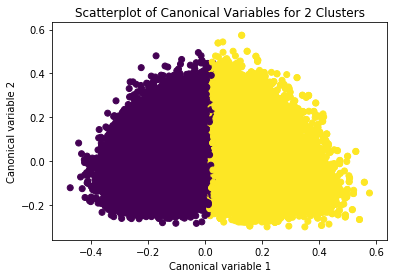

<Figure size 21600x7200 with 0 Axes>

Top 50 terms per cluster:

Cluster 0 words:
 PC_8, PC_9, PC_14, PC_22, PC_12, PC_13, PC_23, PC_7, PC_11, PC_25, PC_16, PC_18, PC_15, PC_2, PC_5, PC_19, PC_21, PC_6, PC_17, PC_20, PC_10, PC_24, PC_3, PC_4, PC_1,Cluster 1 words:
 PC_1, PC_4, PC_3, PC_24, PC_10, PC_20, PC_17, PC_6, PC_21, PC_19, PC_5, PC_2, PC_15, PC_18, PC_16, PC_25, PC_11, PC_7, PC_23, PC_13, PC_12, PC_22, PC_14, PC_9, PC_8,

In [61]:
#Based on elbow plot selected 2 cluster solution

#TFIDFdata
#TFIDF_PCAOP
#Based optimal clusters, build cluster solution on all data (train)
ClusterOP=Clusters(TFIDF_PCAOP,'cluster_model_PCA_F500.sav',k=2)

In [62]:
#Define the function to compute summary stats of cluster solution
def clusterstats(IP):
    print("No.of records per cluster")
    print(IP['Clusterid'].value_counts())
    print("\n")
    print("Average values of cluster inputs")
    clustersummary=IP.groupby('Clusterid').mean()
    return clustersummary

In [63]:
#Call the cluster summary function on all data (train)
clusterstats(ClusterOP)

No.of records per cluster
0    27777
1    20719
Name: Clusterid, dtype: int64


Average values of cluster inputs


able    accept    access    accord   account       act  \
Clusterid                                                               
0          0.012595  0.009173  0.003908  0.005248  0.029290  0.006221   
1          0.009582  0.005739  0.008273  0.004094  0.104649  0.007018   

             action  actually       add  addition    ...         wife  \
Clusterid                                            ...                
0          0.007562   0.00472  0.008332  0.004412    ...     0.007635   
1          0.006992   0.00493  0.008397  0.003423    ...     0.005720   

             within   without      work     would     write     wrong  \
Clusterid                                                               
0          0.007736  0.011216  0.023779  0.041569  0.013123  0.007018   
1          0.009798  0.017140  0.008708  0.038684  0.010929  0.006064   

               year     years       yet  
Clusterid                                
0          0.018401  0.024645  0.010061  
1          0.010552  0.017019  0.008209  

[2 rows x 500 columns]

# Reading the FTC Act document for key word search for creating UFDP bag of words(using domain understanding)

In [64]:
FTCActTxt = open("ftca.txt", "rb").read()
#FTCActTxt

In [65]:
#Initialize an empty list to hold the clean texts
Corpus_FTCAct = []

start = time.time()

Corpus_FTCAct.append(text_to_words(FTCActTxt))

end = time. time()
print(end - start)

0.0506720542908


Time elapsed for execution =  1.86368703842


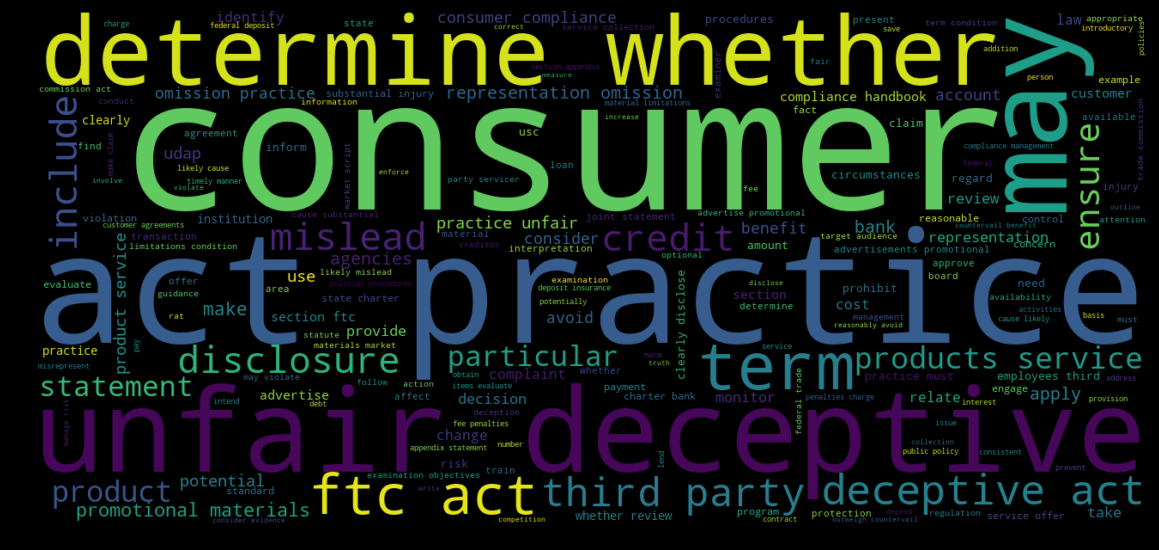

In [66]:
#Creat word cloud of FTC Act key words
#Call function. Provide the IP and OP paremeters
wordcloud(Corpus_FTCAct,'FTCAct.png')

In [72]:
#Create bag of word model/tockenization/Creating Sparse metrics for the FTC Act text data
#Call TF function with IP, OP , maxfeatures and ngram parameters 
#Try uni, bi and trigrams
TF_FTCAct_data=TF(Corpus_FTCAct,'FTCActKeywords.csv',ngram=1,MAXFEATURES=None)

In [73]:
TF_FTCAct_data

ability  able  abusive  acceptable  accordance  accordingly  account  \
0        3     4        2           1           1            1       14   

   accountholders  accurate  accurately  ...    whether  whole  wider  wisdom  \
0               1         4           2  ...         61      1      1       1   

   withhold  within  without  work  would  write  
0         1       1        3     1      4      4  

[1 rows x 818 columns]

In [76]:
#POS Tag
from nltk import pos_tag
from sklearn.feature_extraction.text import CountVectorizer

tf_vectorizer = CountVectorizer(ngram_range=(1,1)) 
tf = tf_vectorizer.fit_transform(Corpus_FTCAct)

tokens_pos = pos_tag(tf_vectorizer.get_feature_names())
Corpus_FTCAct_POStg=pd.DataFrame(tokens_pos)
Corpus_FTCAct_POStg.columns = ['keywords', 'pos']
Corpus_FTCAct_POStg.to_csv('FTCActKeywords_postg.csv')

# 2) Grievance closed with explanation and Disputed Status (Y)

# Text Mine for communication effectiveness keywords in such grievance description texts

In [77]:
#Subset the data as per requirement
df_filtered=df1[(df1.ResolutionComments=='Closed with explanation') & (df1.Disputed=="Yes")]
df_filtered=df_filtered.loc[:, ['GrievanceDescription']]

#store the no.of obs in an object
num_texts = df_filtered["GrievanceDescription"].size
print(num_texts)

#Reset the index of the filtered data
df_filtered.reset_index()
df_filtered=df_filtered.reset_index(drop=True)

9202


In [78]:
#Call function cleantxt to make the corpus of clean text
clean_reviews1=cleantxt(df_filtered,rec=num_texts)

Time elapsed for execution =  12.8074769974


Time elapsed for execution =  10.654638052


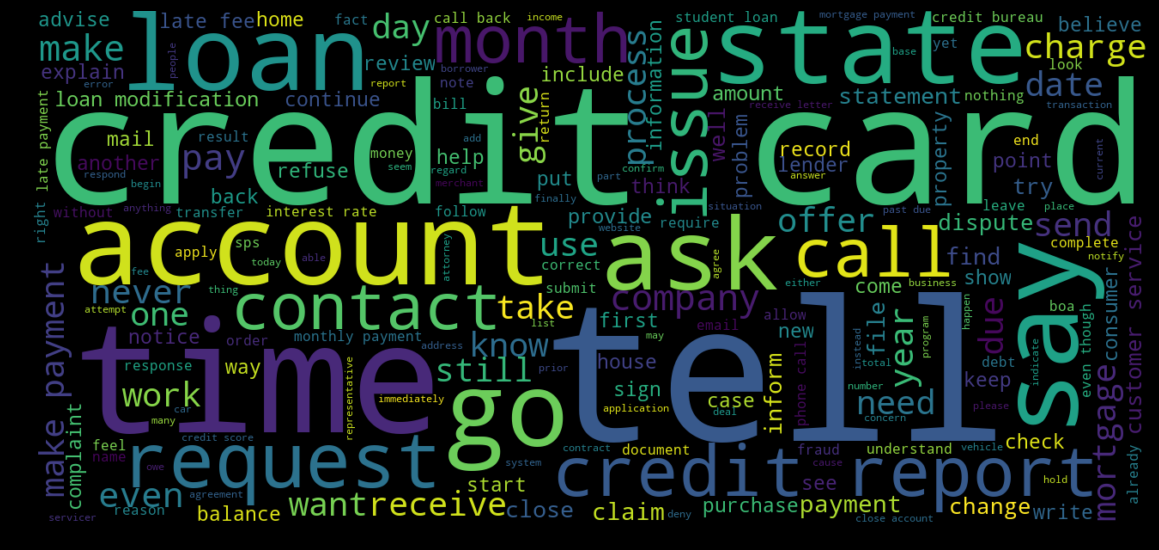

In [79]:
#Creat word cloud
#Call function. Provide the IP and OP paremeters
wordcloud(clean_reviews1,'Closedwithexp_Dispute.png')

In [81]:
#BOW_CWE_DISPTD=['understand','follow','finally','deny','receive','inform','require','feel','confirm','still','back','situation','believe','point','change','tell','give','say','refuse','time','state','ask','information','never','send','respond','credit report','issue','request','call back','even though','continue','notice']
#BOW_CWE_DISPTD


# 3) Text Mine grievance description for line of business - Credit Card

In [67]:
#Subset the data as per requirement
df_filtered=df1[(df1.LineOfBusiness=='Credit card')]
df_filtered=df_filtered.loc[:, ['GrievanceDescription']]

#store the no.of obs in an object
num_texts = df_filtered["GrievanceDescription"].size
print(num_texts)

#Reset the index of the filtered data
df_filtered.reset_index()
df_filtered=df_filtered.reset_index(drop=True)

19909


In [68]:
#Call function cleantxt to make the corpus of clean text
clean_reviews2=cleantxt(df_filtered,rec=num_texts)

Time elapsed for execution =  22.697674036


Time elapsed for execution =  13.535984993


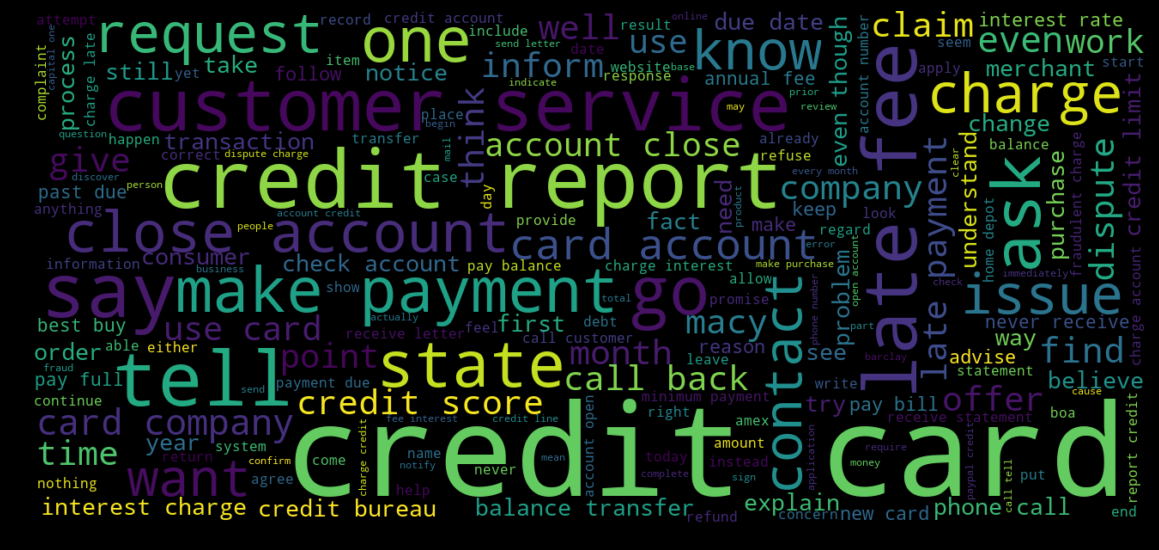

In [69]:
#Creat word cloud
#Call function. Provide the IP and OP paremeters
wordcloud(clean_reviews2,'BusinessCC.png')

# 4) Text Mine grievance description for line of business - Mortgage

In [33]:
#Subset the data as per requirement
df_filtered=df1[(df1.LineOfBusiness=='Mortgage')]
df_filtered=df_filtered.loc[:, ['GrievanceDescription']]

#store the no.of obs in an object
num_texts = df_filtered["GrievanceDescription"].size
print(num_texts)

#Reset the index of the filtered data
df_filtered.reset_index()
df_filtered=df_filtered.reset_index(drop=True)

18956


In [34]:
#Call function cleantxt to make the corpus of clean text
clean_reviews3=cleantxt(df_filtered,rec=num_texts)

Time elapsed for execution =  26.8909800053


Time elapsed for execution =  20.9458901882


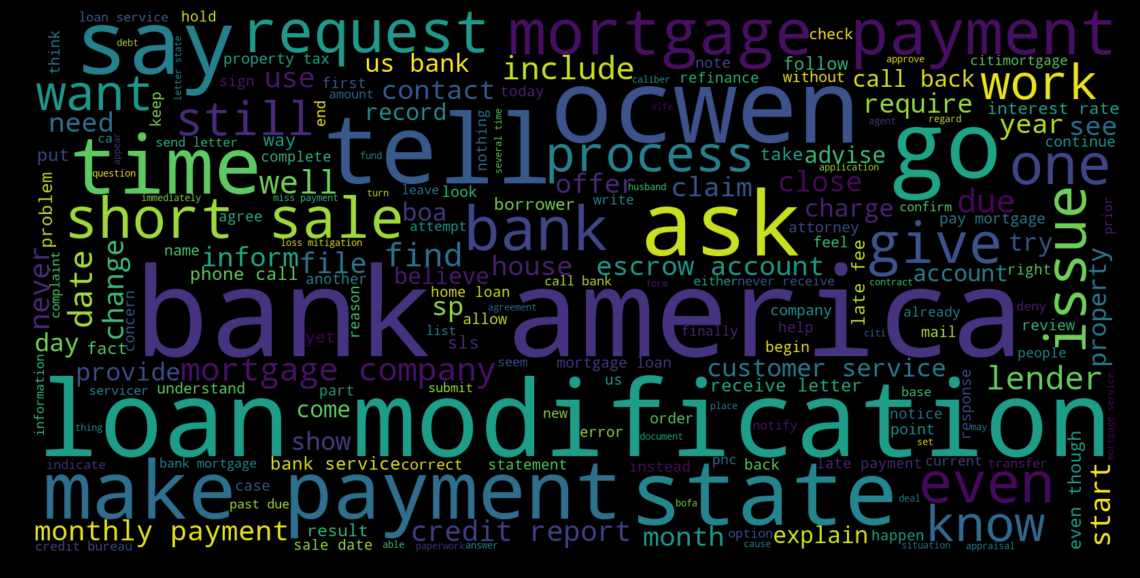

In [35]:
#Creat word cloud
#Call function. Provide the IP and OP paremeters
wordcloud(clean_reviews3,'BusinessMortgage.png')

# 5) Text Mine to understand the severity of Grievance Category -> Dealing with my lender or servicer

In [36]:
#Subset the data as per requirement
df_filtered=df1[(df1.Grievance_Category=='Dealing with my lender or servicer')]
df_filtered=df_filtered.loc[:, ['GrievanceDescription']]

#store the no.of obs in an object
num_texts = df_filtered["GrievanceDescription"].size
print(num_texts)

#Reset the index of the filtered data
df_filtered.reset_index()
df_filtered=df_filtered.reset_index(drop=True)

2821


In [37]:
#Call function cleantxt to make the corpus of clean text
clean_reviews4=cleantxt(df_filtered,rec=num_texts)

Time elapsed for execution =  3.57691788673


Time elapsed for execution =  5.99421191216


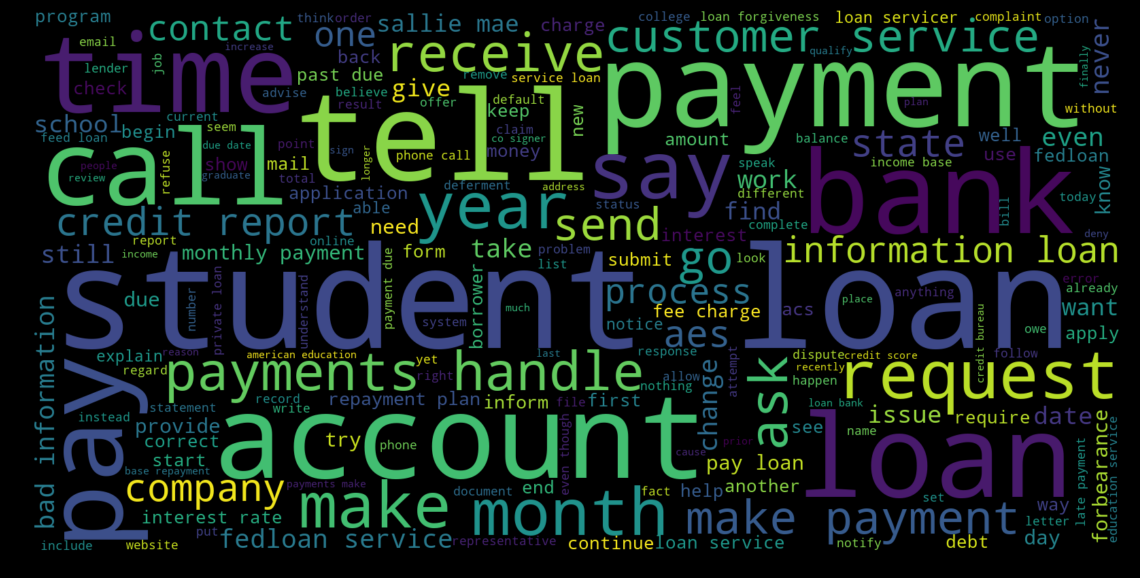

In [38]:
#Creat word cloud
#Call function. Provide the IP and OP paremeters
wordcloud(clean_reviews4,'DealingwithlenderServicer.png')

# 6) Text Mine to understand the severity of Grievance Category -> Loan servicing, payments, escrow account

In [39]:
#Subset the data as per requirement
df_filtered=df1[(df1.Grievance_Category=='Loan servicing, payments, escrow account')]
df_filtered=df_filtered.loc[:, ['GrievanceDescription']]

#store the no.of obs in an object
num_texts = df_filtered["GrievanceDescription"].size
print(num_texts)

#Reset the index of the filtered data
df_filtered.reset_index()
df_filtered=df_filtered.reset_index(drop=True)

7499


In [40]:
#Call function cleantxt to make the corpus of clean text
clean_reviews5=cleantxt(df_filtered,rec=num_texts)

Time elapsed for execution =  9.79068398476


Time elapsed for execution =  9.64273691177


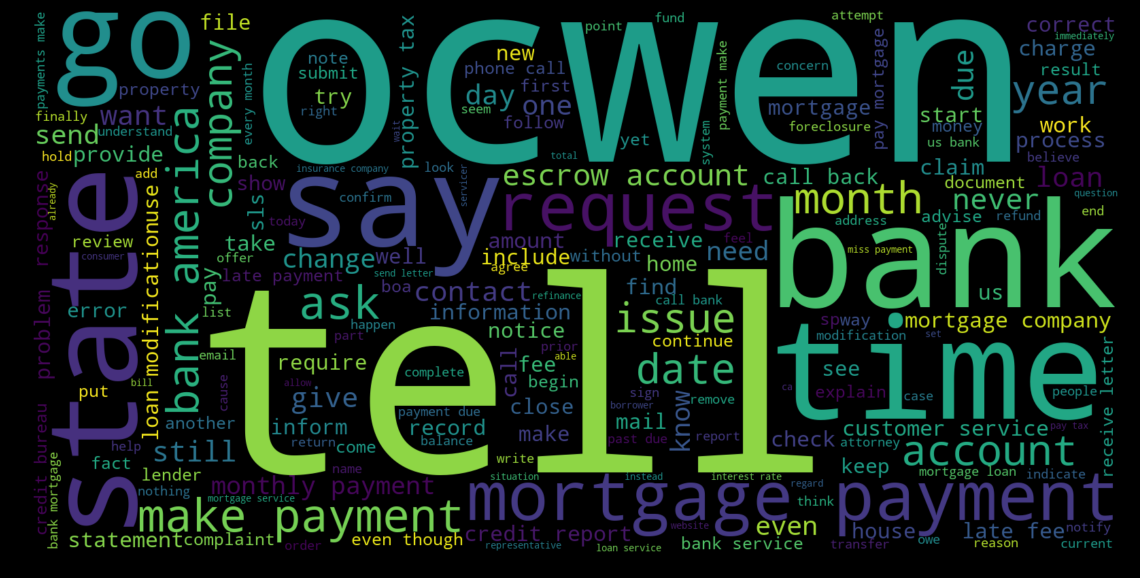

In [41]:
#Creat word cloud
#Call function. Provide the IP and OP paremeters
wordcloud(clean_reviews5,'LoanService_Payments_escrow.png')

# 7) Text Mine to understand the severity of Grievance Category -> Loan modification,collection,foreclosure

In [42]:
#Subset the data as per requirement
df_filtered=df1[(df1.Grievance_Category=='Loan modification,collection,foreclosure')]
df_filtered=df_filtered.loc[:, ['GrievanceDescription']]

#store the no.of obs in an object
num_texts = df_filtered["GrievanceDescription"].size
print(num_texts)

#Reset the index of the filtered data
df_filtered.reset_index()
df_filtered=df_filtered.reset_index(drop=True)

5761


In [43]:
#Call function cleantxt to make the corpus of clean text
clean_reviews6=cleantxt(df_filtered,rec=num_texts)

Time elapsed for execution =  8.39544391632


Time elapsed for execution =  9.62347197533


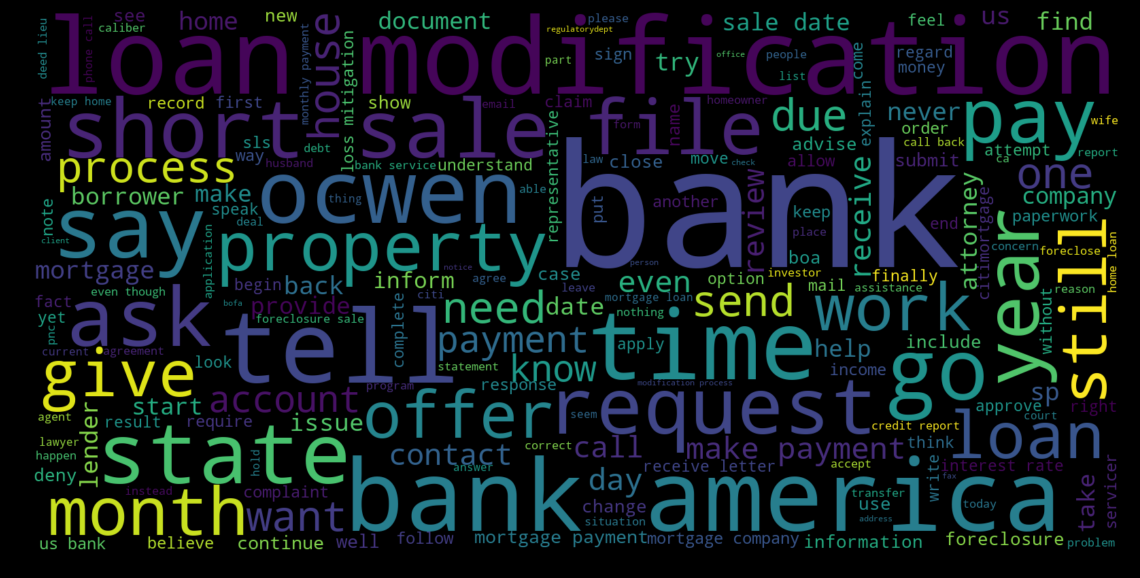

In [44]:
#Creat word cloud
#Call function. Provide the IP and OP paremeters
wordcloud(clean_reviews6,'LoanModify_Collection_ForeClosure.png')

# Part 2

# Feature extractions at grievance level

#### 1) Clustering (UFDP/Non-UFDP)

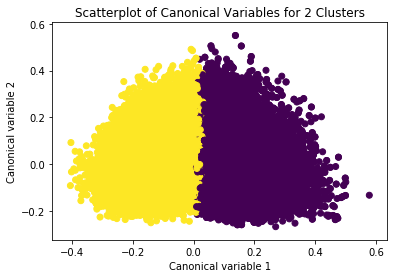

<Figure size 21600x7200 with 0 Axes>

Top 50 terms per cluster:

Cluster 0 words:
 card, credit, account, charge, report, pay, call, balance, payment, fee, late, receive, would, make, tell, close, bill, interest, dispute, use, time, say, get, purchase, never, due, company, statement, send, check, open, information, remove, issue, service, macy, number, ask, days, customer, contact, back, payments, amount, letter, fraud, request, date, phone, month,Cluster 1 words:
 loan, mortgage, payment, pay, payments, call, make, get, would, time, modification, tell, home, receive, send, say, company, request, service, go, letter, account, amount, interest, state, take, information, property, due, document, ask, month, back, need, escrow, help, try, years, foreclosure, insurance, contact, never, work, tax, date, process, sale, since, file, could,No.of records per cluster
1    27706
0    20790
Name: Clusterid, dtype: int64


Average values of cluster inputs


ability      able  absolutely    accept    access    accord  \
Clusterid                                                                 
0          0.002212  0.008423    0.002021  0.004954  0.007291  0.003558   
1          0.002278  0.010921    0.001896  0.008006  0.003355  0.004523   

            account    accrue      acct  accurate    ...        would  \
Clusterid                                            ...                
0          0.092099  0.003136  0.003043  0.002549    ...     0.034139   
1          0.025571  0.002863  0.001630  0.002001    ...     0.036153   

              write     wrong  xxxxxxxxxxxx      year     years       yes  \
Clusterid                                                                   
0          0.009611  0.005325      0.001150  0.009185  0.014952  0.001928   
1          0.011296  0.006134      0.001993  0.016067  0.021478  0.001995   

           yesterday       yet      zero  
Clusterid                                 
0           0.002105  0.007266  0.003181  
1           0.002102  0.008765  0.000840  

[2 rows x 1000 columns]

In [98]:
#Call all the required functions defined above for building 2 cluster (optimal as per elbow chart above) solution

#TFIDFdata=TFIDF(clean_reviews,'TFIDFData1000_1.csv',ngram=1,MAXFEATURES=1000)
#ClusterOP=Clusters(TFIDFdata,'cluster_model_RD_F1000.sav',k=2)
#clusterstats(ClusterOP)

In [99]:
#Used the fitted (train) model on test

#load the model from disk
#loaded_model = pickle.load(open('cluster_model_RD_F1000.sav', 'rb'))
#result = loaded_model.predict(TFIDFdata)
#print(result)

[1 1 0 ... 1 1 1]


In [100]:
#ClusterOP.head(1)
#ClusterOP.shape
#df1.shape

(48496, 1001)

In [101]:
#Join the cluster ids and the raw IP data
frames = [ClusterOP["Clusterid"], df1]
DF_UFDP_C = pd.concat(frames,axis=1)
#Renaming cluster ID
DF_UFDP_C.rename(columns={'Clusterid': 'ClusterUFDP'}, inplace=True)

In [105]:
#DF_UFDP_C

## 2) Grievance Description -> BOB (14 corpus), to create 14 new features

#### New features include following

#### 1)BusinessPractices -> Business practices/ plans/programs/protections
#### 2)Communication -> More to do with negative/missleading communication, customer service experience
#### 3)CIBILScore -> Redit report/score impact
#### 4)LateFeeInterestCharges -> Late fee/ interest charges issues
#### 5)Payments -> payment instructions followups
#### 6)CloseCancel -> Request to close,cancel,stop,card,account,payments
#### 7)purchase -> purchase related concerns
#### 8)DelayRecur -> Delayed responses/ recurring issues
#### 9)legal -> involves legal actions/parties
#### 10)Mkting_Offer_Reward -> Marketing, offers, promotions,advertisements
#### 11)PaymentIssue -> Issues related with payments
#### 12)MortgageBroadly -> Broader concerns in mortgage loans
#### 13)TeftFraudThreat -> Theft, fraud, threat,abuses
#### 14)UFDP -> Critical/Core issues that can be tagged as UFDP



#### Join the clean descriptions with the original data for creating features out of it

In [147]:
#Convert the clean_reviews list to dataframe
clean_reviews
clean_reviews_df = pd.DataFrame({'GrievanceDesc_clean':clean_reviews})
clean_reviews_df.shape
clean_reviews_df.head(2)

#Join the cleaned reviews with orignal data

frames = [clean_reviews_df, df1]
df2 = pd.concat(frames,axis=1)

df2=  df2[['GrievanceDesc_clean','GrievanceID','LineOfBusiness','ResolutionComments','Disputed']]
#df2.shape
#df2.head(1)
#df1
num_texts = df2['GrievanceDesc_clean'].size
num_texts

48496

#### Import the BOW corpus for creating features (UFDP and other features)

In [148]:
BOWcorpus=pd.read_csv('BOW_NEW.csv')

In [149]:
#Import Pandas SQL library
from pandasql import *
import pandas as pd

#### Feature -> BusinessPractices

In [150]:
BOW = BOWcorpus[BOWcorpus["BusinessPractices"].notnull()]
BOW=BOW[["BusinessPractices"]]

num_keywords = BOW["BusinessPractices"].size
num_keywords

BOW = BOW.rename(columns={'BusinessPractices': 'list'})

pysqldf = lambda q: sqldf(q, globals())

q = """SELECT df2.*,BOW.* FROM df2 LEFT JOIN BOW ON df2.GrievanceDesc_clean LIKE '%' || BOW.list || '%'"""
df3 = pysqldf(q)

df3.loc[:, ['list']] = df3[['list']].notnull() * 1

df3.drop_duplicates(subset=None, keep='first', inplace=True)
df3 = df3.rename(columns={'list': 'BusinessPractices'})

print("Look at the distribution")
print(df3['BusinessPractices'].value_counts())

df3.reset_index()
df3=df3.reset_index(drop=True)
frames = [df2, df3['BusinessPractices']]
FeatureData = pd.concat(frames,axis=1)

Look at the distribution
0    36847
1    11649
Name: BusinessPractices, dtype: int64


#### Feature -> Communication

In [151]:
BOW = BOWcorpus[BOWcorpus["Communication"].notnull()]
BOW=BOW[["Communication"]]

num_keywords = BOW["Communication"].size
num_keywords

BOW = BOW.rename(columns={'Communication': 'list'})

pysqldf = lambda q: sqldf(q, globals())

q = """SELECT df2.*,BOW.* FROM df2 LEFT JOIN BOW ON df2.GrievanceDesc_clean LIKE '%' || BOW.list || '%'"""
df3 = pysqldf(q)

df3.loc[:, ['list']] = df3[['list']].notnull() * 1

df3.drop_duplicates(subset=None, keep='first', inplace=True)
df3 = df3.rename(columns={'list': 'Communication'})

print("Look at the distribution")
print(df3['Communication'].value_counts())

df3.reset_index()
df3=df3.reset_index(drop=True)
frames = [FeatureData, df3['Communication']]
df2 = pd.concat(frames,axis=1)
FeatureData = pd.concat(frames,axis=1)

Look at the distribution
1    30453
0    18043
Name: Communication, dtype: int64


#### Feature -> CIBILScore

In [152]:
BOW = BOWcorpus[BOWcorpus["CIBILScore"].notnull()]
BOW=BOW[["CIBILScore"]]

num_keywords = BOW["CIBILScore"].size
num_keywords

BOW = BOW.rename(columns={'CIBILScore': 'list'})

pysqldf = lambda q: sqldf(q, globals())

q = """SELECT df2.*,BOW.* FROM df2 LEFT JOIN BOW ON df2.GrievanceDesc_clean LIKE '%' || BOW.list || '%'"""
df3 = pysqldf(q)

df3.loc[:, ['list']] = df3[['list']].notnull() * 1

df3.drop_duplicates(subset=None, keep='first', inplace=True)
df3 = df3.rename(columns={'list': 'CIBILScore'})

print("Look at the distribution")
print(df3['CIBILScore'].value_counts())

df3.reset_index()
df3=df3.reset_index(drop=True)
frames = [FeatureData, df3['CIBILScore']]
df2 = pd.concat(frames,axis=1)
FeatureData = pd.concat(frames,axis=1)

Look at the distribution
0    38595
1     9901
Name: CIBILScore, dtype: int64


#### Feature -> LateFeeInterestCharges

In [153]:
BOW = BOWcorpus[BOWcorpus["LateFeeInterestCharges"].notnull()]
BOW=BOW[["LateFeeInterestCharges"]]

num_keywords = BOW["LateFeeInterestCharges"].size
num_keywords

BOW = BOW.rename(columns={'LateFeeInterestCharges': 'list'})

pysqldf = lambda q: sqldf(q, globals())

q = """SELECT df2.*,BOW.* FROM df2 LEFT JOIN BOW ON df2.GrievanceDesc_clean LIKE '%' || BOW.list || '%'"""
df3 = pysqldf(q)

df3.loc[:, ['list']] = df3[['list']].notnull() * 1

df3.drop_duplicates(subset=None, keep='first', inplace=True)
df3 = df3.rename(columns={'list': 'LateFeeInterestCharges'})

print("Look at the distribution")
print(df3['LateFeeInterestCharges'].value_counts())

df3.reset_index()
df3=df3.reset_index(drop=True)
frames = [FeatureData, df3['LateFeeInterestCharges']]
df2 = pd.concat(frames,axis=1)
FeatureData = pd.concat(frames,axis=1)

Look at the distribution
0    33563
1    14933
Name: LateFeeInterestCharges, dtype: int64


#### Feature -> Payments

In [154]:
BOW = BOWcorpus[BOWcorpus["Payments"].notnull()]
BOW=BOW[["Payments"]]

num_keywords = BOW["Payments"].size
num_keywords

BOW = BOW.rename(columns={'Payments': 'list'})

pysqldf = lambda q: sqldf(q, globals())

q = """SELECT df2.*,BOW.* FROM df2 LEFT JOIN BOW ON df2.GrievanceDesc_clean LIKE '%' || BOW.list || '%'"""
df3 = pysqldf(q)

df3.loc[:, ['list']] = df3[['list']].notnull() * 1

df3.drop_duplicates(subset=None, keep='first', inplace=True)
df3 = df3.rename(columns={'list': 'Payments'})

print("Look at the distribution")
print(df3['Payments'].value_counts())

df3.reset_index()
df3=df3.reset_index(drop=True)
frames = [FeatureData, df3['Payments']]
df2 = pd.concat(frames,axis=1)
FeatureData = pd.concat(frames,axis=1)

Look at the distribution
0    35112
1    13384
Name: Payments, dtype: int64


#### Feature -> CloseCancel


In [155]:
BOW = BOWcorpus[BOWcorpus["CloseCancel"].notnull()]
BOW=BOW[["CloseCancel"]]

num_keywords = BOW["CloseCancel"].size
num_keywords

BOW = BOW.rename(columns={'CloseCancel': 'list'})

pysqldf = lambda q: sqldf(q, globals())

q = """SELECT df2.*,BOW.* FROM df2 LEFT JOIN BOW ON df2.GrievanceDesc_clean LIKE '%' || BOW.list || '%'"""
df3 = pysqldf(q)

df3.loc[:, ['list']] = df3[['list']].notnull() * 1

df3.drop_duplicates(subset=None, keep='first', inplace=True)
df3 = df3.rename(columns={'list': 'CloseCancel'})

print("Look at the distribution")
print(df3['CloseCancel'].value_counts())

df3.reset_index()
df3=df3.reset_index(drop=True)
frames = [FeatureData, df3['CloseCancel']]
df2 = pd.concat(frames,axis=1)
FeatureData = pd.concat(frames,axis=1)

Look at the distribution
0    33926
1    14570
Name: CloseCancel, dtype: int64


#### Feature -> purchase

In [156]:
BOW = BOWcorpus[BOWcorpus["purchase"].notnull()]
BOW=BOW[["purchase"]]

num_keywords = BOW["purchase"].size
num_keywords

BOW = BOW.rename(columns={'purchase': 'list'})

pysqldf = lambda q: sqldf(q, globals())

q = """SELECT df2.*,BOW.* FROM df2 LEFT JOIN BOW ON df2.GrievanceDesc_clean LIKE '%' || BOW.list || '%'"""
df3 = pysqldf(q)

df3.loc[:, ['list']] = df3[['list']].notnull() * 1

df3.drop_duplicates(subset=None, keep='first', inplace=True)
df3 = df3.rename(columns={'list': 'purchase'})

print("Look at the distribution")
print(df3['purchase'].value_counts())

df3.reset_index()
df3=df3.reset_index(drop=True)
frames = [FeatureData, df3['purchase']]
df2 = pd.concat(frames,axis=1)
FeatureData = pd.concat(frames,axis=1)

Look at the distribution
0    41312
1     7184
Name: purchase, dtype: int64


#### Feature -> DelayRecur

In [157]:
BOW = BOWcorpus[BOWcorpus["DelayRecur"].notnull()]
BOW=BOW[["DelayRecur"]]

num_keywords = BOW["DelayRecur"].size
num_keywords

BOW = BOW.rename(columns={'DelayRecur': 'list'})

pysqldf = lambda q: sqldf(q, globals())

q = """SELECT df2.*,BOW.* FROM df2 LEFT JOIN BOW ON df2.GrievanceDesc_clean LIKE '%' || BOW.list || '%'"""
df3 = pysqldf(q)

df3.loc[:, ['list']] = df3[['list']].notnull() * 1

df3.drop_duplicates(subset=None, keep='first', inplace=True)
df3 = df3.rename(columns={'list': 'DelayRecur'})

print("Look at the distribution")
print(df3['DelayRecur'].value_counts())

df3.reset_index()
df3=df3.reset_index(drop=True)
frames = [FeatureData, df3['DelayRecur']]
df2 = pd.concat(frames,axis=1)
FeatureData = pd.concat(frames,axis=1)

Look at the distribution
1    34541
0    13955
Name: DelayRecur, dtype: int64


#### Feature -> legal

In [158]:
BOW = BOWcorpus[BOWcorpus["legal"].notnull()]
BOW=BOW[["legal"]]

num_keywords = BOW["legal"].size
num_keywords

BOW = BOW.rename(columns={'legal': 'list'})

pysqldf = lambda q: sqldf(q, globals())

q = """SELECT df2.*,BOW.* FROM df2 LEFT JOIN BOW ON df2.GrievanceDesc_clean LIKE '%' || BOW.list || '%'"""
df3 = pysqldf(q)

df3.loc[:, ['list']] = df3[['list']].notnull() * 1

df3.drop_duplicates(subset=None, keep='first', inplace=True)
df3 = df3.rename(columns={'list': 'legal'})

print("Look at the distribution")
print(df3['legal'].value_counts())

df3.reset_index()
df3=df3.reset_index(drop=True)
frames = [FeatureData, df3['legal']]
df2 = pd.concat(frames,axis=1)
FeatureData = pd.concat(frames,axis=1)

Look at the distribution
0    28520
1    19976
Name: legal, dtype: int64


#### Feature -> Mkting_Offer_Reward

In [159]:
BOW = BOWcorpus[BOWcorpus["Mkting_Offer_Reward"].notnull()]
BOW=BOW[["Mkting_Offer_Reward"]]

num_keywords = BOW["Mkting_Offer_Reward"].size
num_keywords

BOW = BOW.rename(columns={'Mkting_Offer_Reward': 'list'})

pysqldf = lambda q: sqldf(q, globals())

q = """SELECT df2.*,BOW.* FROM df2 LEFT JOIN BOW ON df2.GrievanceDesc_clean LIKE '%' || BOW.list || '%'"""
df3 = pysqldf(q)

df3.loc[:, ['list']] = df3[['list']].notnull() * 1

df3.drop_duplicates(subset=None, keep='first', inplace=True)
df3 = df3.rename(columns={'list': 'Mkting_Offer_Reward'})

print("Look at the distribution")
print(df3['Mkting_Offer_Reward'].value_counts())

df3.reset_index()
df3=df3.reset_index(drop=True)
frames = [FeatureData, df3['Mkting_Offer_Reward']]
df2 = pd.concat(frames,axis=1)
FeatureData = pd.concat(frames,axis=1)

Look at the distribution
0    37711
1    10785
Name: Mkting_Offer_Reward, dtype: int64


#### Feature -> PaymentIssue

In [160]:
BOW = BOWcorpus[BOWcorpus["PaymentIssue"].notnull()]
BOW=BOW[["PaymentIssue"]]

num_keywords = BOW["PaymentIssue"].size
num_keywords

BOW = BOW.rename(columns={'PaymentIssue': 'list'})

pysqldf = lambda q: sqldf(q, globals())

q = """SELECT df2.*,BOW.* FROM df2 LEFT JOIN BOW ON df2.GrievanceDesc_clean LIKE '%' || BOW.list || '%'"""
df3 = pysqldf(q)

df3.loc[:, ['list']] = df3[['list']].notnull() * 1

df3.drop_duplicates(subset=None, keep='first', inplace=True)
df3 = df3.rename(columns={'list': 'PaymentIssue'})

print("Look at the distribution")
print(df3['PaymentIssue'].value_counts())

df3.reset_index()
df3=df3.reset_index(drop=True)
frames = [FeatureData, df3['PaymentIssue']]
df2 = pd.concat(frames,axis=1)
FeatureData = pd.concat(frames,axis=1)

Look at the distribution
1    30847
0    17649
Name: PaymentIssue, dtype: int64


### Feature -> MortgageBroadly

In [161]:
BOW = BOWcorpus[BOWcorpus["MortgageBroadly"].notnull()]
BOW=BOW[["MortgageBroadly"]]

num_keywords = BOW["MortgageBroadly"].size
num_keywords

BOW = BOW.rename(columns={'MortgageBroadly': 'list'})

pysqldf = lambda q: sqldf(q, globals())

q = """SELECT df2.*,BOW.* FROM df2 LEFT JOIN BOW ON df2.GrievanceDesc_clean LIKE '%' || BOW.list || '%'"""
df3 = pysqldf(q)

df3.loc[:, ['list']] = df3[['list']].notnull() * 1

df3.drop_duplicates(subset=None, keep='first', inplace=True)
df3 = df3.rename(columns={'list': 'MortgageBroadly'})

print("Look at the distribution")
print(df3['MortgageBroadly'].value_counts())

df3.reset_index()
df3=df3.reset_index(drop=True)
frames = [FeatureData, df3['MortgageBroadly']]
df2 = pd.concat(frames,axis=1)
FeatureData = pd.concat(frames,axis=1)

Look at the distribution
0    30863
1    17633
Name: MortgageBroadly, dtype: int64


#### Feature -> TeftFraudThreat

In [162]:
BOW = BOWcorpus[BOWcorpus["TeftFraudThreat"].notnull()]
BOW=BOW[["TeftFraudThreat"]]

num_keywords = BOW["TeftFraudThreat"].size
num_keywords

BOW = BOW.rename(columns={'TeftFraudThreat': 'list'})

pysqldf = lambda q: sqldf(q, globals())

q = """SELECT df2.*,BOW.* FROM df2 LEFT JOIN BOW ON df2.GrievanceDesc_clean LIKE '%' || BOW.list || '%'"""
df3 = pysqldf(q)

df3.loc[:, ['list']] = df3[['list']].notnull() * 1

df3.drop_duplicates(subset=None, keep='first', inplace=True)
df3 = df3.rename(columns={'list': 'TeftFraudThreat'})

print("Look at the distribution")
print(df3['TeftFraudThreat'].value_counts())

df3.reset_index()
df3=df3.reset_index(drop=True)
frames = [FeatureData, df3['TeftFraudThreat']]
df2 = pd.concat(frames,axis=1)
FeatureData = pd.concat(frames,axis=1)

Look at the distribution
0    40757
1     7739
Name: TeftFraudThreat, dtype: int64


#### Feature -> UFDP

In [163]:
BOW = BOWcorpus[BOWcorpus["UFDP"].notnull()]
BOW=BOW[["UFDP"]]

num_keywords = BOW["UFDP"].size
num_keywords

BOW = BOW.rename(columns={'UFDP': 'list'})

pysqldf = lambda q: sqldf(q, globals())

q = """SELECT df2.*,BOW.* FROM df2 LEFT JOIN BOW ON df2.GrievanceDesc_clean LIKE '%' || BOW.list || '%'"""
df3 = pysqldf(q)

df3.loc[:, ['list']] = df3[['list']].notnull() * 1

df3.drop_duplicates(subset=None, keep='first', inplace=True)
df3 = df3.rename(columns={'list': 'UFDP'})

print("Look at the distribution")
print(df3['UFDP'].value_counts())

df3.reset_index()
df3=df3.reset_index(drop=True)
frames = [FeatureData, df3['UFDP']]
df2 = pd.concat(frames,axis=1)
FeatureData = pd.concat(frames,axis=1)

Look at the distribution
1    29181
0    19315
Name: UFDP, dtype: int64


#### Final data at grievance level with all the original columns, cleaned grievance description , and derived features from text

In [164]:
Add_data=  df1[['BankID','State','DateOfGrievance','Grievance_Category','DateOfResolution']]
frames = [FeatureData, Add_data]
FinalGrievanceDt = pd.concat(frames,axis=1)

In [166]:
FinalGrievanceDt.shape
#FinalGrievanceDt.head(1)

(48496, 24)

# 3) Deriving new feature -> Daystoresolve, difference between DateOfResolution and DateOfGrievance


In [167]:
FinalGrievanceDt['Daystoresolve']=((pd.to_datetime(FinalGrievanceDt['DateOfResolution']))-(pd.to_datetime(FinalGrievanceDt['DateOfGrievance']))).dt.days

#### Save the final grievance level dataframe to pickle

In [168]:
#FinalGrievanceDt.to_pickle('FinalGrievanceDt_Saved.pkl') 

In [6]:
FinalGrievanceDt = pd.read_pickle('FinalGrievanceDt_Saved.pkl')

# Part 3

# EDA on the final grievance level data

## 1) Trend in grievance over years

In [450]:
#FinalGrievanceDt.head(1)

In [35]:
FinalGrievanceDt['Yearsflg']='NA'
FinalGrievanceDt['Yearsflg'][(FinalGrievanceDt['DateOfGrievance'] > '2015-03-31') & (FinalGrievanceDt['DateOfGrievance'] <= '2016-03-31')] = 'Y15Apr_Yr16Mar'
FinalGrievanceDt['Yearsflg'][(FinalGrievanceDt['DateOfGrievance'] > '2014-03-31') & (FinalGrievanceDt['DateOfGrievance'] <= '2015-03-31')] = 'Y14Apr_Yr15Mar'
FinalGrievanceDt['Yearsflg'][(FinalGrievanceDt['DateOfGrievance'] > '2013-03-31') & (FinalGrievanceDt['DateOfGrievance'] <= '2014-03-31')] = 'Y13Apr_Yr14Mar'
FinalGrievanceDt['Yearsflg'][(FinalGrievanceDt['DateOfGrievance'] > '2012-03-31') & (FinalGrievanceDt['DateOfGrievance'] <= '2013-03-31')] = 'Y12Apr_Yr13Mar'

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda2/lib/python2.7/site-packages/ip

In [507]:
#FinalGrievanceDt[(FinalGrievanceDt['DateOfGrievance'] > '2013-01-01') & (FinalGrievanceDt['DateOfGrievance'] < '2014-02-01')]

In [36]:
GrievanceCntYr = FinalGrievanceDt[['Yearsflg','GrievanceID']].groupby(['Yearsflg'])['GrievanceID'].count().reset_index(name='No.ofGrievance').sort_values(['No.ofGrievance'])#,ascending=False                                              

In [37]:
GrievanceCntYr.set_index("Yearsflg",drop=True,inplace=True)

In [38]:
GrievanceCntYr=GrievanceCntYr.sort_values(by=['Yearsflg'])
GrievanceCntYr

No.ofGrievance
Yearsflg                      
Y12Apr_Yr13Mar           20099
Y13Apr_Yr14Mar           22944
Y14Apr_Yr15Mar            4436
Y15Apr_Yr16Mar            1017

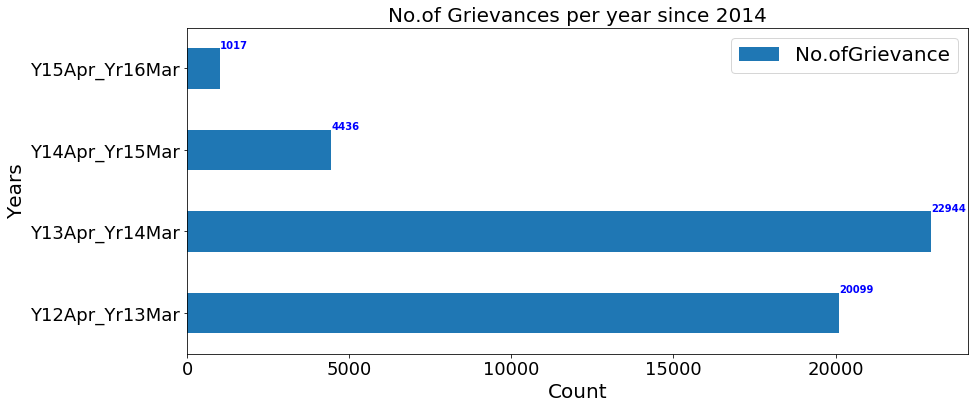

In [40]:
import matplotlib.pyplot as plt
ax = GrievanceCntYr[['No.ofGrievance']].plot(kind='barh', title ="No.of Grievances per year since 2014", figsize=(14, 6), legend=True, fontsize=18)
ax.set_xlabel("Count", fontsize=20)
ax.set_ylabel("Years", fontsize=20)
plt.legend(fontsize=20)
plt.rc('axes', titlesize=20)

values=GrievanceCntYr["No.ofGrievance"].tolist()

for i, v in enumerate(values):
    ax.text(v + 3, i + .25, str(v), color='blue', fontweight='bold')
    
#plt.show()

plt.savefig('Daystoresolve.png',bbox_inches='tight')

#### Grievance trend has increased till 2013 - 2014, but but some strange dip is noticed after that

## 2) Top 5 banks with highest recorded grievance since 2014

In [533]:
Top5banks = FinalGrievanceDt[['BankID','GrievanceID']].groupby(['BankID'])['GrievanceID'].count().reset_index(name='No.ofGrievance').sort_values(['No.ofGrievance'],ascending=False).head(5)

In [534]:
Top5banks.set_index("BankID",drop=True,inplace=True)
Top5banks=Top5banks.sort_values(by=['No.ofGrievance'])

No.ofGrievance
BankID                  
Bank5277            2031
Bank5382            3467
Bank5285            3672
Bank5257            4660
Bank5286            5023

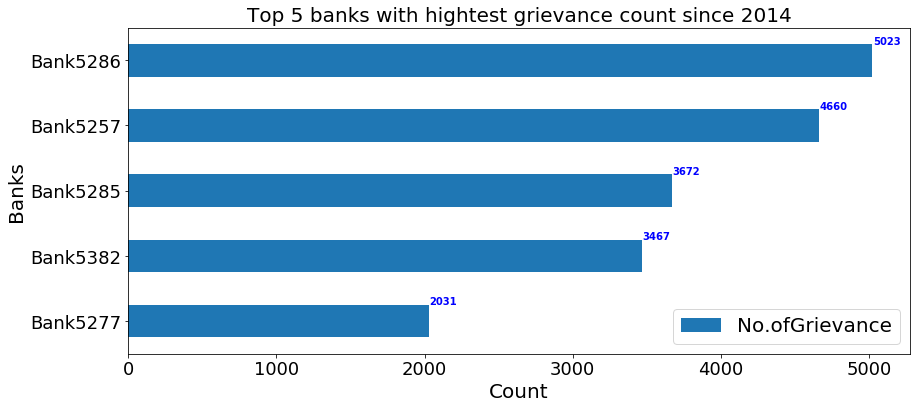

In [535]:
import matplotlib.pyplot as plt
ax = Top5banks[['No.ofGrievance']].plot(kind='barh', title ="Top 5 banks with hightest grievance count since 2014", figsize=(14, 6), legend=True, fontsize=18)
ax.set_xlabel("Count", fontsize=20)
ax.set_ylabel("Banks", fontsize=20)
plt.legend(fontsize=20)
plt.rc('axes', titlesize=20)

values=Top5banks["No.ofGrievance"].tolist()

for i, v in enumerate(values):
    ax.text(v + 3, i + .25, str(v), color='blue', fontweight='bold')
    
plt.show()

## 3) Top 5 states with highest recorded grievance since 2014 (Avg per bank grievance)

In [600]:
GrievStateCnt = FinalGrievanceDt[['State','GrievanceID']].groupby(['State'])['GrievanceID'].count().reset_index(name='No.ofGrievance')

In [601]:
StateBankCnt = FinalGrievanceDt[['State','BankID']].groupby(['State'])['BankID'].nunique().reset_index(name='No.ofBanks')

In [602]:
StateLevelGriev=GrievStateCnt.set_index('State').join(StateBankCnt.set_index('State'))
StateLevelGriev['AvgGrievPerBank'] = (StateLevelGriev['No.ofGrievance']/StateLevelGriev['No.ofBanks']).round(0)

In [603]:
Top5states=StateLevelGriev.sort_values(by=['AvgGrievPerBank'],ascending=False).head(5)

In [604]:
Top5states=Top5states.sort_values(by=['AvgGrievPerBank'],ascending=True)

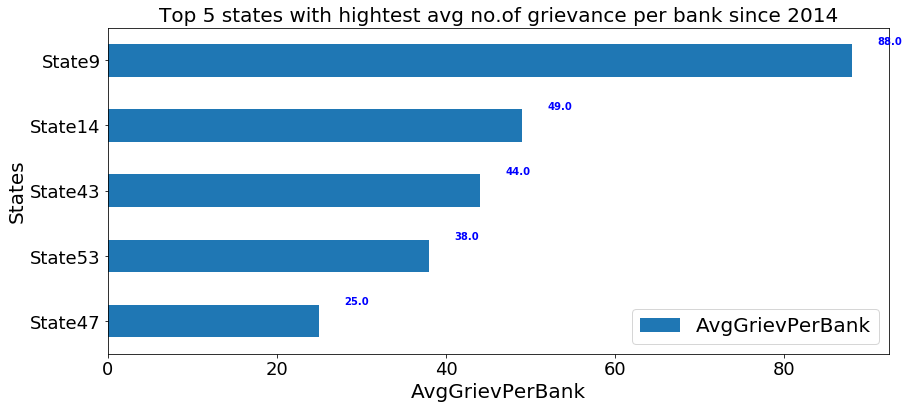

In [605]:
import matplotlib.pyplot as plt
ax = Top5states[['AvgGrievPerBank']].plot(kind='barh', title ="Top 5 states with hightest avg no.of grievance per bank since 2014", figsize=(14, 6), legend=True, fontsize=18)
ax.set_xlabel("AvgGrievPerBank", fontsize=20)
ax.set_ylabel("States", fontsize=20)
plt.legend(fontsize=20)
plt.rc('axes', titlesize=20)

values=Top5states["AvgGrievPerBank"].tolist()

for i, v in enumerate(values):
    ax.text(v + 3, i + .25, str(v), color='blue', fontweight='bold')
    
plt.show()

#### State 9 is having highest average grievance per bank
#### Create additional 5 features to flag is the back is in each of this 5 states

## 4) Visualize the distribution of days to resolve (derived column -Daystoresolve)

In [7]:
Daystoresolve = FinalGrievanceDt["Daystoresolve"].tolist()

In [8]:
FinalGrievanceDt['DaystoResolveflg']='NA'
FinalGrievanceDt['DaystoResolveflg'][(FinalGrievanceDt['Daystoresolve'] <= 30)] = '1Monthorless'
FinalGrievanceDt['DaystoResolveflg'][(FinalGrievanceDt['Daystoresolve'] > 30) & (FinalGrievanceDt['Daystoresolve'] <= 60)] = '1to2Months'
FinalGrievanceDt['DaystoResolveflg'][(FinalGrievanceDt['Daystoresolve'] > 60) & (FinalGrievanceDt['Daystoresolve'] <= 90)] = '2to3Months'
FinalGrievanceDt['DaystoResolveflg'][(FinalGrievanceDt['Daystoresolve'] > 90)] = '3Monthsormore'

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda2/lib/python2.7/site-packages/ip

In [9]:
GrievanceCntResolveBkt = FinalGrievanceDt[['DaystoResolveflg','GrievanceID']].groupby(['DaystoResolveflg'])['GrievanceID'].count().reset_index(name='No.ofGrievance').sort_values(['No.ofGrievance'])#,ascending=False    

In [10]:
GrievanceCntResolveBkt['Pct_GrievanceResolved'] = (((GrievanceCntResolveBkt['No.ofGrievance']/48496))*100).round(3)

In [11]:
GrievanceCntResolveBkt=GrievanceCntResolveBkt.sort_values(by=['DaystoResolveflg'],ascending=True)
GrievanceCntResolveBkt.set_index("DaystoResolveflg",drop=True,inplace=True)

In [12]:
GrievanceCntResolveBkt

No.ofGrievance  Pct_GrievanceResolved
DaystoResolveflg                                       
1Monthorless               42869                 88.397
1to2Months                  5389                 11.112
2to3Months                   203                  0.419
3Monthsormore                 35                  0.072

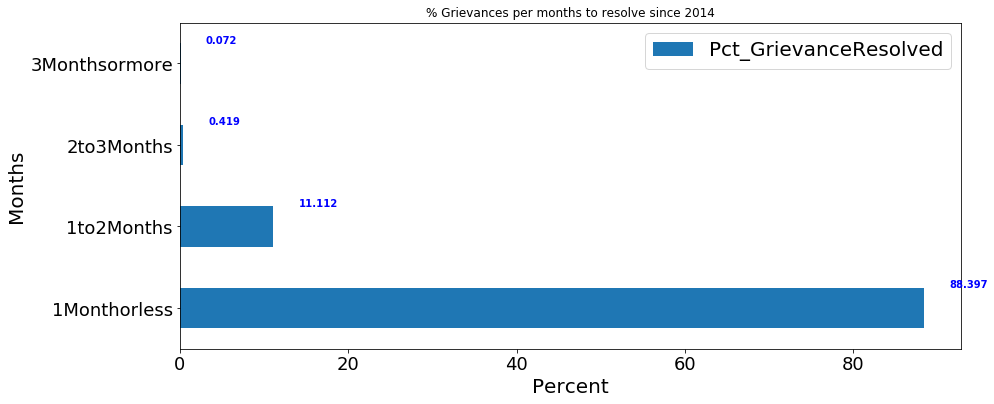

In [13]:
import matplotlib.pyplot as plt
ax = GrievanceCntResolveBkt[['Pct_GrievanceResolved']].plot(kind='barh', title ="% Grievances per months to resolve since 2014", figsize=(14, 6), legend=True, fontsize=18)
ax.set_xlabel("Percent", fontsize=20)
ax.set_ylabel("Months", fontsize=20)
plt.legend(fontsize=20)
plt.rc('axes', titlesize=20)

values=GrievanceCntResolveBkt["Pct_GrievanceResolved"].tolist()

for i, v in enumerate(values):
    ax.text(v + 3, i + .25, str(v), color='blue', fontweight='bold')
    
plt.show()

#### About 89% of the grievance over the past 4 years have taken <1 months to resolve, as per industry standards. 
#### >1Months are are interesting to observe in the model if they impact bank score

## 5) Distribution of the grievance issues by business line of operation

In [14]:
GrievanceCntBusinessln = FinalGrievanceDt[['LineOfBusiness','GrievanceID']].groupby(['LineOfBusiness'])['GrievanceID'].count().reset_index(name='No.ofGrievance').sort_values(['No.ofGrievance'])#,ascending=False    

In [15]:
GrievanceCntBusinessln['Pct_Grievance'] = (((GrievanceCntBusinessln['No.ofGrievance']/48496))*100).round(3)

In [16]:
GrievanceCntBusinessln=GrievanceCntBusinessln.sort_values(by=['LineOfBusiness'],ascending=True)
GrievanceCntBusinessln.set_index("LineOfBusiness",drop=True,inplace=True)

In [17]:
GrievanceCntBusinessln

No.ofGrievance  Pct_Grievance
LineOfBusiness                               
Consumer Loan             4939         10.184
Credit card              19909         41.053
Mortgage                 18956         39.088
Student loan              4692          9.675

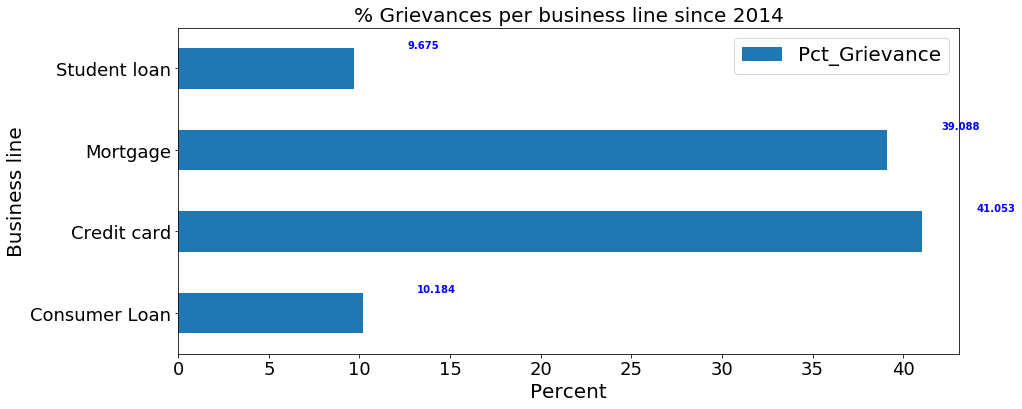

In [18]:
import matplotlib.pyplot as plt
ax = GrievanceCntBusinessln[['Pct_Grievance']].plot(kind='barh', title ="% Grievances per business line since 2014", figsize=(14, 6), legend=True, fontsize=18)
ax.set_xlabel("Percent", fontsize=20)
ax.set_ylabel("Business line", fontsize=20)
plt.legend(fontsize=20)
plt.rc('axes', titlesize=20)

values=GrievanceCntBusinessln["Pct_Grievance"].tolist()

for i, v in enumerate(values):
    ax.text(v + 3, i + .25, str(v), color='blue', fontweight='bold')
    
plt.show()

#### mortgage and Credit card business is having highest no.of grieveance incidents (avg. 40%)

## 6) Distribution of communicational issues for grieveance closed with explanation and disputed

#### Communicational issues is derived column from grievance text

In [19]:
ClosedExpDisp = FinalGrievanceDt[(FinalGrievanceDt['ResolutionComments']=='Closed with explanation') & (FinalGrievanceDt['Disputed']=='Yes')]

In [20]:
GrievanceCntComm = ClosedExpDisp[['Communication','GrievanceID']].groupby(['Communication'])['GrievanceID'].count().reset_index(name='No.ofGrievance').sort_values(['No.ofGrievance'])#,ascending=False    

In [21]:
GrievanceCntComm['CommunicationIssueFlg'] = np.where(GrievanceCntComm['Communication']==1, 'yes', 'no')

In [22]:
GrievanceCntComm['Pct_Grievance'] = (((GrievanceCntComm['No.ofGrievance']/9202))*100).round(3)

In [23]:
GrievanceCntComm=GrievanceCntComm.sort_values(by=['CommunicationIssueFlg'],ascending=False)
GrievanceCntComm.set_index("CommunicationIssueFlg",drop=True,inplace=True)

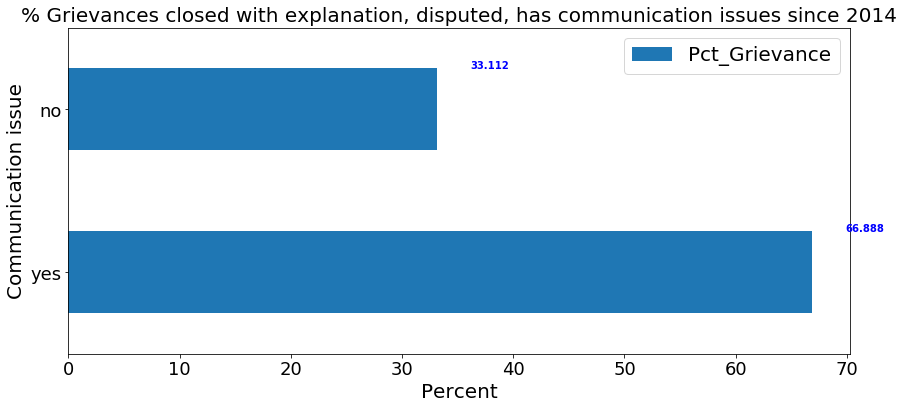

In [24]:
import matplotlib.pyplot as plt
ax = GrievanceCntComm[['Pct_Grievance']].plot(kind='barh', title ="% Grievances closed with explanation, disputed, has communication issues since 2014", figsize=(14, 6), legend=True, fontsize=18)
ax.set_xlabel("Percent", fontsize=20)
ax.set_ylabel("Communication issue", fontsize=20)
plt.legend(fontsize=20)
plt.rc('axes', titlesize=20)

values=GrievanceCntComm["Pct_Grievance"].tolist()

for i, v in enumerate(values):
    ax.text(v + 3, i + .25, str(v), color='blue', fontweight='bold')
    
plt.show()

#### There were 9202 out of 48496 grievences that are closed with explanation and disputes
#### Out of 9202 about 67 % are noticed to have communicational issues

## 7) Distribution of grieveances having CIBIL Score related issues 

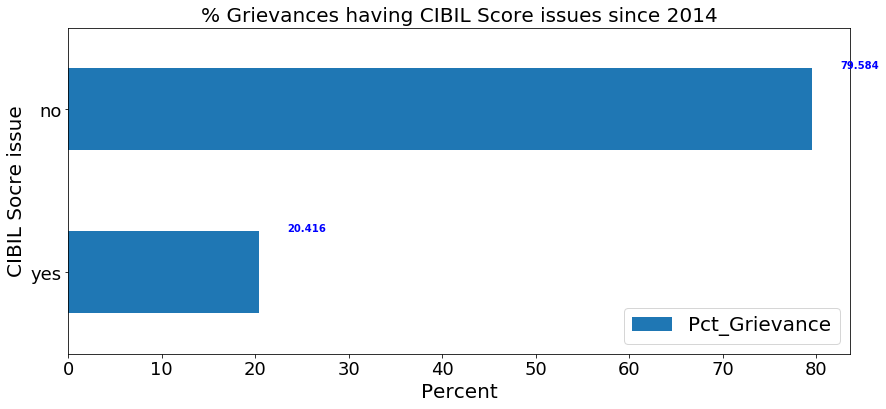

In [25]:

GrievanceCntCIBIL = FinalGrievanceDt[['CIBILScore','GrievanceID']].groupby(['CIBILScore'])['GrievanceID'].count().reset_index(name='No.ofGrievance').sort_values(['No.ofGrievance'])
GrievanceCntCIBIL['CIBIEScore_IssueFlg'] = np.where(GrievanceCntCIBIL['CIBILScore']==1, 'yes', 'no')
GrievanceCntCIBIL['Pct_Grievance'] = (((GrievanceCntCIBIL['No.ofGrievance']/48496))*100).round(3)
GrievanceCntCIBIL=GrievanceCntCIBIL.sort_values(by=['CIBIEScore_IssueFlg'],ascending=False)
GrievanceCntCIBIL.set_index("CIBIEScore_IssueFlg",drop=True,inplace=True)

import matplotlib.pyplot as plt
ax = GrievanceCntCIBIL[['Pct_Grievance']].plot(kind='barh', title ="% Grievances having CIBIL Score issues since 2014", figsize=(14, 6), legend=True, fontsize=18)
ax.set_xlabel("Percent", fontsize=20)
ax.set_ylabel("CIBIL Socre issue", fontsize=20)
plt.legend(fontsize=20)
plt.rc('axes', titlesize=20)

values=GrievanceCntCIBIL["Pct_Grievance"].tolist()

for i, v in enumerate(values):
    ax.text(v + 3, i + .25, str(v), color='blue', fontweight='bold')
    
plt.show()


#### We have aount 20% grievance issues related to CIBIL Scores of customers

In [706]:
FinalGrievanceDt.head(1)

GrievanceDesc_clean GrievanceID  \
0  research dpt ca name customer loan refinance h...   GID512411   

  LineOfBusiness       ResolutionComments Disputed BusinessPractices  \
0       Mortgage  Closed with explanation       No                 0   

  Communication CIBILScore LateFeeInterestCharges Payments       ...         \
0             0          0                      0        0       ...          

  TeftFraudThreat UFDP    BankID    State DateOfGrievance  \
0               0    0  Bank5279  State31      2016-01-19   

             Grievance_Category DateOfResolution Daystoresolve  \
0  Settlement process and costs       2016-01-30            11   

         Yearsflg DaystoResolveflg  
0  Y15Apr_Yr16Mar     1Monthorless  

[1 rows x 27 columns]

## 8) Distribution of grieveances having Late fee/ Interest charges  related issues 

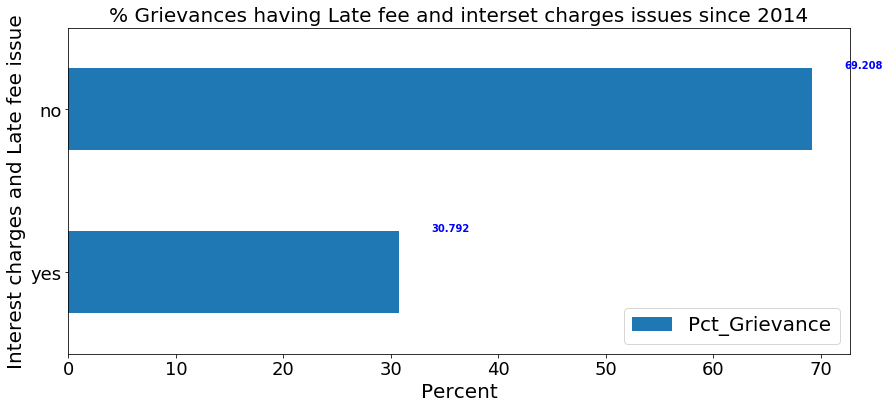

In [26]:
GrievanceCntLatefee = FinalGrievanceDt[['LateFeeInterestCharges','GrievanceID']].groupby(['LateFeeInterestCharges'])['GrievanceID'].count().reset_index(name='No.ofGrievance').sort_values(['No.ofGrievance'])
GrievanceCntLatefee['Latefee_InterestCharges_IssueFlg'] = np.where(GrievanceCntLatefee['LateFeeInterestCharges']==1, 'yes', 'no')
GrievanceCntLatefee['Pct_Grievance'] = (((GrievanceCntLatefee['No.ofGrievance']/48496))*100).round(3)
GrievanceCntLatefee=GrievanceCntLatefee.sort_values(by=['Latefee_InterestCharges_IssueFlg'],ascending=False)
GrievanceCntLatefee.set_index("Latefee_InterestCharges_IssueFlg",drop=True,inplace=True)

import matplotlib.pyplot as plt
ax = GrievanceCntLatefee[['Pct_Grievance']].plot(kind='barh', title ="% Grievances having Late fee and interset charges issues since 2014", figsize=(14, 6), legend=True, fontsize=18)
ax.set_xlabel("Percent", fontsize=20)
ax.set_ylabel("Interest charges and Late fee issue", fontsize=20)
plt.legend(fontsize=20)
plt.rc('axes', titlesize=20)

values=GrievanceCntLatefee["Pct_Grievance"].tolist()

for i, v in enumerate(values):
    ax.text(v + 3, i + .25, str(v), color='blue', fontweight='bold')
    
plt.show()


## 8) Distribution of grieveances having Marketing and offer related issues

In [27]:
#Mkting_Offer_Reward

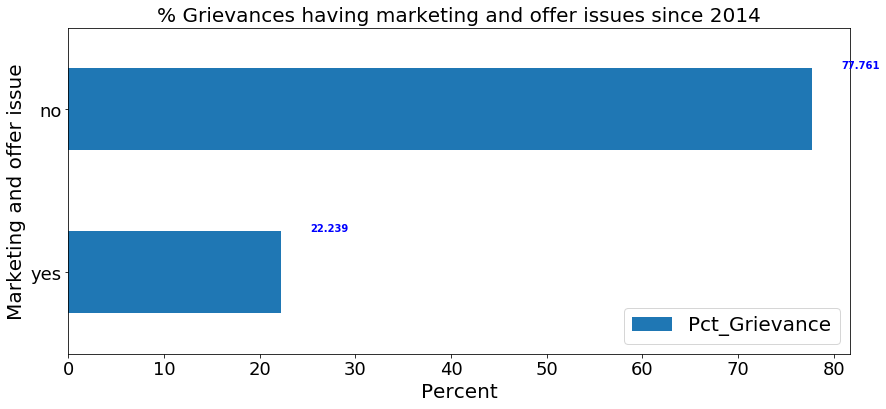

In [28]:
GrievanceCntMarket = FinalGrievanceDt[['Mkting_Offer_Reward','GrievanceID']].groupby(['Mkting_Offer_Reward'])['GrievanceID'].count().reset_index(name='No.ofGrievance').sort_values(['No.ofGrievance'])
GrievanceCntMarket['Mkt_Offer_IssueFlg'] = np.where(GrievanceCntMarket['Mkting_Offer_Reward']==1, 'yes', 'no')
GrievanceCntMarket['Pct_Grievance'] = (((GrievanceCntMarket['No.ofGrievance']/48496))*100).round(3)
GrievanceCntMarket=GrievanceCntMarket.sort_values(by=['Mkt_Offer_IssueFlg'],ascending=False)
GrievanceCntMarket.set_index("Mkt_Offer_IssueFlg",drop=True,inplace=True)

import matplotlib.pyplot as plt
ax = GrievanceCntMarket[['Pct_Grievance']].plot(kind='barh', title ="% Grievances having marketing and offer issues since 2014", figsize=(14, 6), legend=True, fontsize=18)
ax.set_xlabel("Percent", fontsize=20)
ax.set_ylabel("Marketing and offer issue", fontsize=20)
plt.legend(fontsize=20)
plt.rc('axes', titlesize=20)

values=GrievanceCntMarket["Pct_Grievance"].tolist()

for i, v in enumerate(values):
    ax.text(v + 3, i + .25, str(v), color='blue', fontweight='bold')
    
plt.show()


#### About 22% grievances have marketing and offer related issues

## 8) Distribution of grieveances having delays and recurrance related issues

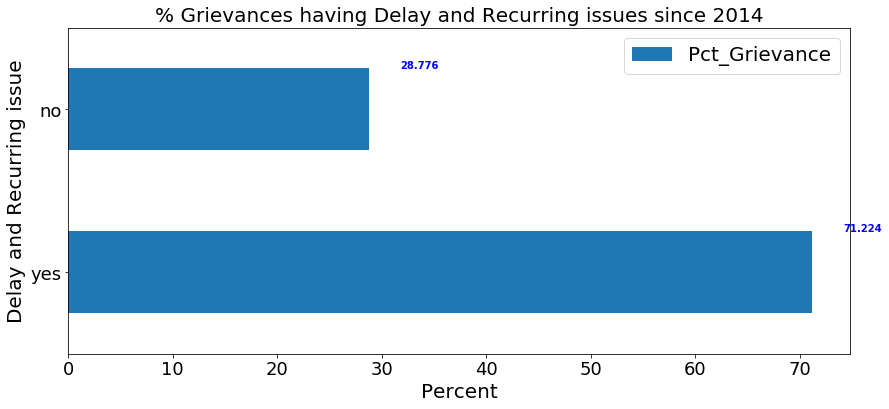

In [29]:
GrievanceCntDelay = FinalGrievanceDt[['DelayRecur','GrievanceID']].groupby(['DelayRecur'])['GrievanceID'].count().reset_index(name='No.ofGrievance').sort_values(['No.ofGrievance'])
GrievanceCntDelay['Delay_RecurringIssueFlg'] = np.where(GrievanceCntDelay['DelayRecur']==1, 'yes', 'no')
GrievanceCntDelay['Pct_Grievance'] = (((GrievanceCntDelay['No.ofGrievance']/48496))*100).round(3)
GrievanceCntDelay=GrievanceCntDelay.sort_values(by=['Delay_RecurringIssueFlg'],ascending=False)
GrievanceCntDelay.set_index("Delay_RecurringIssueFlg",drop=True,inplace=True)

import matplotlib.pyplot as plt
ax = GrievanceCntDelay[['Pct_Grievance']].plot(kind='barh', title ="% Grievances having Delay and Recurring issues since 2014", figsize=(14, 6), legend=True, fontsize=18)
ax.set_xlabel("Percent", fontsize=20)
ax.set_ylabel("Delay and Recurring issue", fontsize=20)
plt.legend(fontsize=20)
plt.rc('axes', titlesize=20)

values=GrievanceCntDelay["Pct_Grievance"].tolist()

for i, v in enumerate(values):
    ax.text(v + 3, i + .25, str(v), color='blue', fontweight='bold')
    
plt.show()


#### About 71% grievances have delay and recurring issues

## 8) Distribution of grieveances having UFDP issues

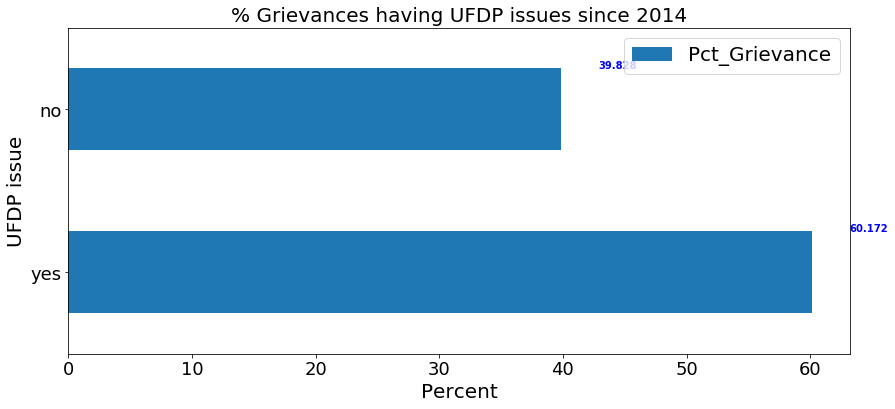

In [30]:
GrievanceCntUFDP = FinalGrievanceDt[['UFDP','GrievanceID']].groupby(['UFDP'])['GrievanceID'].count().reset_index(name='No.ofGrievance').sort_values(['No.ofGrievance'])
GrievanceCntUFDP['UFDP_IssueFlg'] = np.where(GrievanceCntUFDP['UFDP']==1, 'yes', 'no')
GrievanceCntUFDP['Pct_Grievance'] = (((GrievanceCntUFDP['No.ofGrievance']/48496))*100).round(3)
GrievanceCntUFDP=GrievanceCntUFDP.sort_values(by=['UFDP_IssueFlg'],ascending=False)
GrievanceCntUFDP.set_index("UFDP_IssueFlg",drop=True,inplace=True)

import matplotlib.pyplot as plt
ax = GrievanceCntUFDP[['Pct_Grievance']].plot(kind='barh', title ="% Grievances having UFDP issues since 2014", figsize=(14, 6), legend=True, fontsize=18)
ax.set_xlabel("Percent", fontsize=20)
ax.set_ylabel("UFDP issue", fontsize=20)
plt.legend(fontsize=20)
plt.rc('axes', titlesize=20)

values=GrievanceCntUFDP["Pct_Grievance"].tolist()

for i, v in enumerate(values):
    ax.text(v + 3, i + .25, str(v), color='blue', fontweight='bold')
    
plt.show()


#### About 60% have UFDP issues

## Feature extraction using state, line of business, days to resolve grievance issues   

#### Creating 5 additional features flags for top 5 (highest grievance issues) states

In [31]:
FinalGrievanceDt['State9'] = np.where(FinalGrievanceDt['State']=='State9', 1, 0)
FinalGrievanceDt['State14'] = np.where(FinalGrievanceDt['State']=='State14', 1, 0)
FinalGrievanceDt['State43'] = np.where(FinalGrievanceDt['State']=='State43', 1, 0)
FinalGrievanceDt['State53'] = np.where(FinalGrievanceDt['State']=='State53', 1, 0)
FinalGrievanceDt['State47'] = np.where(FinalGrievanceDt['State']=='State47', 1, 0)

#### Creating 2 variables using line of business for mortgage and credit cards

In [170]:
FinalGrievanceDt['Mortgage'] = np.where(FinalGrievanceDt['LineOfBusiness']=='Mortgage', 1, 0)
FinalGrievanceDt['CreditCard'] = np.where(FinalGrievanceDt['LineOfBusiness']=='Credit card', 1, 0)

#### Creating 4 additional variables for days to resolve 

In [178]:
FinalGrievanceDt['Lessthan1Month'] = np.where(FinalGrievanceDt['DaystoResolveflg']=='1Monthorless', 1, 0)
FinalGrievanceDt['1to2Months'] = np.where(FinalGrievanceDt['DaystoResolveflg']=='1to2Months', 1, 0)
FinalGrievanceDt['2to3Months'] = np.where(FinalGrievanceDt['DaystoResolveflg']=='2to3Months', 1, 0)
FinalGrievanceDt['3Monthsormore'] = np.where(FinalGrievanceDt['DaystoResolveflg']=='3Monthsormore', 1, 0)

#### Create 1 additional variable for closed with explanation grievances 

In [179]:
FinalGrievanceDt['ClosedwithExplain'] = np.where(FinalGrievanceDt['ResolutionComments']=='Closed with explanation', 1, 0)

#### Create 1 additional variable for closed with explanation and disputed grievances

In [180]:
FinalGrievanceDt['ClosedwithExplain_Dispute'] = np.where((FinalGrievanceDt['ResolutionComments']=='Closed with explanation') & (FinalGrievanceDt['Disputed']=='Yes'), 1, 0)

#### Create 1 additional variable for closed with explanation , disputed and having communication issues


In [181]:
FinalGrievanceDt['ClosedwithExplain_Dispute_Commu'] = np.where((FinalGrievanceDt['ResolutionComments']=='Closed with explanation') & (FinalGrievanceDt['Disputed']=='Yes') & (FinalGrievanceDt['Communication']==1), 1, 0)

In [759]:
#names = FinalGrievanceDt.columns.values 
#names1=pd.DataFrame(names)

In [183]:
FinalGrievanceDt.shape

(48496, 40)

In [184]:
#FinalGrievanceDt.to_pickle('FinalGrievanceDt_Additional_Saved.pkl') 
#FinalGrievanceDt = pd.read_pickle('FinalGrievanceDt_Saved.pkl')

# Part 4 -> Data preparation at bank level for model building

# Data Role up at Bank level (all derived features)

In [243]:
## 1) Import Bank level Target variable
BankTarget=pd.read_csv('BankTarget.csv')

#### Roll up the features at bank level

#### All the derived features at grievance level are flag (1/0) variables. 
#### Role up by counting the occurances of each features / issues at bank level 
#### Compute the % to the total no.of grievance issues per bank

In [244]:
State9 = FinalGrievanceDt[['BankID','State9']].groupby(['BankID'])['State9'].sum().reset_index(name='State9_sum')
State14 = FinalGrievanceDt[['BankID','State14']].groupby(['BankID'])['State14'].sum().reset_index(name='State14_sum')
State43 = FinalGrievanceDt[['BankID','State43']].groupby(['BankID'])['State43'].sum().reset_index(name='State43_sum')
State53 = FinalGrievanceDt[['BankID','State53']].groupby(['BankID'])['State53'].sum().reset_index(name='State53_sum')
State47 = FinalGrievanceDt[['BankID','State47']].groupby(['BankID'])['State47'].sum().reset_index(name='State47_sum')
BusinessPractices = FinalGrievanceDt[['BankID','BusinessPractices']].groupby(['BankID'])['BusinessPractices'].sum().reset_index(name='BusinessPract_Sum')
Communication = FinalGrievanceDt[['BankID','Communication']].groupby(['BankID'])['Communication'].sum().reset_index(name='Communicn_Sum')
CIBILScore = FinalGrievanceDt[['BankID','CIBILScore']].groupby(['BankID'])['CIBILScore'].sum().reset_index(name='CIBILScore_Sum')
LateFeeInterestCharges = FinalGrievanceDt[['BankID','LateFeeInterestCharges']].groupby(['BankID'])['LateFeeInterestCharges'].sum().reset_index(name='LateFeeIntCharg_Sum')
CloseCancel = FinalGrievanceDt[['BankID','CloseCancel']].groupby(['BankID'])['CloseCancel'].sum().reset_index(name='CloseCancel_Sum')
purchase = FinalGrievanceDt[['BankID','purchase']].groupby(['BankID'])['purchase'].sum().reset_index(name='purchaser_Sum')
DelayRecur = FinalGrievanceDt[['BankID','DelayRecur']].groupby(['BankID'])['DelayRecur'].sum().reset_index(name='DelayRecur_Sum')
legal = FinalGrievanceDt[['BankID','legal']].groupby(['BankID'])['legal'].sum().reset_index(name='legal_Sum')
Mkting_Offer_Reward = FinalGrievanceDt[['BankID','Mkting_Offer_Reward']].groupby(['BankID'])['Mkting_Offer_Reward'].sum().reset_index(name='MktOfferRwd_Sum')
PaymentIssue = FinalGrievanceDt[['BankID','PaymentIssue']].groupby(['BankID'])['PaymentIssue'].sum().reset_index(name='PaymentIssue_Sum')
MortgageBroadly = FinalGrievanceDt[['BankID','MortgageBroadly']].groupby(['BankID'])['MortgageBroadly'].sum().reset_index(name='MortgageBroad_Sum')
TeftFraudThreat = FinalGrievanceDt[['BankID','TeftFraudThreat']].groupby(['BankID'])['TeftFraudThreat'].sum().reset_index(name='TeftFraudThreat_Sum')
Mortgage = FinalGrievanceDt[['BankID','Mortgage']].groupby(['BankID'])['Mortgage'].sum().reset_index(name='Mortgage_Sum')
CreditCard = FinalGrievanceDt[['BankID','CreditCard']].groupby(['BankID'])['CreditCard'].sum().reset_index(name='CreditCard_Sum')
Lessthan1Month = FinalGrievanceDt[['BankID','Lessthan1Month']].groupby(['BankID'])['Lessthan1Month'].sum().reset_index(name='Lessthan1Month_Sum')
OnetotwoMonths = FinalGrievanceDt[['BankID','1to2Months']].groupby(['BankID'])['1to2Months'].sum().reset_index(name='1to2Months_Sum')
twotothreeMonths = FinalGrievanceDt[['BankID','2to3Months']].groupby(['BankID'])['2to3Months'].sum().reset_index(name='2to3Months_Sum')
More3months = FinalGrievanceDt[['BankID','3Monthsormore']].groupby(['BankID'])['3Monthsormore'].sum().reset_index(name='3Monthsormore_Sum')
ClosExpl = FinalGrievanceDt[['BankID','ClosedwithExplain']].groupby(['BankID'])['ClosedwithExplain'].sum().reset_index(name='ClosExpl_Sum')
ClosExplDisp = FinalGrievanceDt[['BankID','ClosedwithExplain_Dispute']].groupby(['BankID'])['ClosedwithExplain_Dispute'].sum().reset_index(name='ClosExplDisp_Sum')
ClosExplDispCom = FinalGrievanceDt[['BankID','ClosedwithExplain_Dispute_Commu']].groupby(['BankID'])['ClosedwithExplain_Dispute_Commu'].sum().reset_index(name='ClosExplDispCom_Sum')
CntGriev = FinalGrievanceDt[['BankID','GrievanceID']].groupby(['BankID'])['GrievanceID'].count().reset_index(name='Cnt_Griev')
AvgdaystoRes = FinalGrievanceDt[['BankID','Daystoresolve']].groupby(['BankID'])['Daystoresolve'].mean().reset_index(name='AvgdaystoResolve')
MeddaystoRes = FinalGrievanceDt[['BankID','Daystoresolve']].groupby(['BankID'])['Daystoresolve'].median().reset_index(name='MediandaystoResolve')
Payments = FinalGrievanceDt[['BankID','Payments']].groupby(['BankID'])['Payments'].sum().reset_index(name='Payments_Sum')
UFDP = FinalGrievanceDt[['BankID','UFDP']].groupby(['BankID'])['UFDP'].sum().reset_index(name='UFDP_Sum')

In [245]:
State9.set_index("BankID",drop=True,inplace=True)
State14.set_index("BankID",drop=True,inplace=True)
State43.set_index("BankID",drop=True,inplace=True)
State53.set_index("BankID",drop=True,inplace=True)
State47.set_index("BankID",drop=True,inplace=True)
BusinessPractices.set_index("BankID",drop=True,inplace=True)
Communication.set_index("BankID",drop=True,inplace=True)
CIBILScore.set_index("BankID",drop=True,inplace=True)
LateFeeInterestCharges.set_index("BankID",drop=True,inplace=True)
CloseCancel.set_index("BankID",drop=True,inplace=True)
purchase.set_index("BankID",drop=True,inplace=True)
DelayRecur.set_index("BankID",drop=True,inplace=True)
legal.set_index("BankID",drop=True,inplace=True)
Mkting_Offer_Reward.set_index("BankID",drop=True,inplace=True)
PaymentIssue.set_index("BankID",drop=True,inplace=True)
MortgageBroadly.set_index("BankID",drop=True,inplace=True)
TeftFraudThreat.set_index("BankID",drop=True,inplace=True)
Mortgage.set_index("BankID",drop=True,inplace=True)
CreditCard.set_index("BankID",drop=True,inplace=True)
Lessthan1Month.set_index("BankID",drop=True,inplace=True)
OnetotwoMonths.set_index("BankID",drop=True,inplace=True)
twotothreeMonths.set_index("BankID",drop=True,inplace=True)
More3months.set_index("BankID",drop=True,inplace=True)
ClosExpl.set_index("BankID",drop=True,inplace=True)
ClosExplDisp.set_index("BankID",drop=True,inplace=True)
ClosExplDispCom.set_index("BankID",drop=True,inplace=True)
CntGriev.set_index("BankID",drop=True,inplace=True)
AvgdaystoRes.set_index("BankID",drop=True,inplace=True)
MeddaystoRes.set_index("BankID",drop=True,inplace=True)
Payments.set_index("BankID",drop=True,inplace=True)
UFDP.set_index("BankID",drop=True,inplace=True)

In [246]:
frames = [State9,State14,State43,State53,State47,BusinessPractices,Communication,CIBILScore,LateFeeInterestCharges,CloseCancel,purchase,DelayRecur,legal,Mkting_Offer_Reward,PaymentIssue,MortgageBroadly,TeftFraudThreat,Mortgage,CreditCard,Lessthan1Month,OnetotwoMonths,twotothreeMonths,More3months,ClosExpl,ClosExplDisp,ClosExplDispCom,CntGriev,AvgdaystoRes,MeddaystoRes,Payments,UFDP]
Bankleveldata= pd.concat(frames,axis=1)

In [247]:
FinalBankleveldata = pd.merge(Bankleveldata, BankTarget, how='inner', on=['BankID'])

In [248]:
FinalBankleveldata['State9_pct'] = ((FinalBankleveldata['State9_sum']/FinalBankleveldata['Cnt_Griev'])*100).round(2)
FinalBankleveldata['State14_pct'] = ((FinalBankleveldata['State14_sum']/FinalBankleveldata['Cnt_Griev'])*100).round(2)
FinalBankleveldata['State43_pct'] = ((FinalBankleveldata['State43_sum']/FinalBankleveldata['Cnt_Griev'])*100).round(2)
FinalBankleveldata['State53_pct'] = ((FinalBankleveldata['State53_sum']/FinalBankleveldata['Cnt_Griev'])*100).round(2)
FinalBankleveldata['State47_pct'] = ((FinalBankleveldata['State47_sum']/FinalBankleveldata['Cnt_Griev'])*100).round(2)            
FinalBankleveldata['BusinessPract_pct'] = ((FinalBankleveldata['BusinessPract_Sum']/FinalBankleveldata['Cnt_Griev'])*100).round(2)
FinalBankleveldata['Communicn_pct'] = ((FinalBankleveldata['Communicn_Sum']/FinalBankleveldata['Cnt_Griev'])*100).round(2)
FinalBankleveldata['LateFeeIntCharg_pct'] = ((FinalBankleveldata['LateFeeIntCharg_Sum']/FinalBankleveldata['Cnt_Griev'])*100).round(2)                  
FinalBankleveldata['CIBILScore_pct'] = ((FinalBankleveldata['CIBILScore_Sum']/FinalBankleveldata['Cnt_Griev'])*100).round(2)
FinalBankleveldata['CloseCancel_pct'] = ((FinalBankleveldata['CloseCancel_Sum']/FinalBankleveldata['Cnt_Griev'])*100).round(2)
FinalBankleveldata['purchaser_pct'] = ((FinalBankleveldata['purchaser_Sum']/FinalBankleveldata['Cnt_Griev'])*100).round(2)
FinalBankleveldata['DelayRecur_pct'] = ((FinalBankleveldata['DelayRecur_Sum']/FinalBankleveldata['Cnt_Griev'])*100).round(2)
FinalBankleveldata['legal_pct'] = ((FinalBankleveldata['legal_Sum']/FinalBankleveldata['Cnt_Griev'])*100).round(2)
FinalBankleveldata['MktOfferRwd_pct'] = ((FinalBankleveldata['MktOfferRwd_Sum']/FinalBankleveldata['Cnt_Griev'])*100).round(2)                      
FinalBankleveldata['PaymentIssue_pct'] = ((FinalBankleveldata['PaymentIssue_Sum']/FinalBankleveldata['Cnt_Griev'])*100).round(2)
FinalBankleveldata['MortgageBroad_pct'] = ((FinalBankleveldata['MortgageBroad_Sum']/FinalBankleveldata['Cnt_Griev'])*100).round(2)        
FinalBankleveldata['TeftFraudThreat_pct'] = ((FinalBankleveldata['TeftFraudThreat_Sum']/FinalBankleveldata['Cnt_Griev'])*100).round(2)    
FinalBankleveldata['Mortgage_pct'] = ((FinalBankleveldata['Mortgage_Sum']/FinalBankleveldata['Cnt_Griev'])*100).round(2)                                    
FinalBankleveldata['CreditCard_pct'] = ((FinalBankleveldata['CreditCard_Sum']/FinalBankleveldata['Cnt_Griev'])*100).round(2)                                    
FinalBankleveldata['Lessthan1Month_pct'] = ((FinalBankleveldata['Lessthan1Month_Sum']/FinalBankleveldata['Cnt_Griev'])*100).round(2)                                    
FinalBankleveldata['onetotwoMonths_pct'] = ((FinalBankleveldata['1to2Months_Sum']/FinalBankleveldata['Cnt_Griev'])*100).round(2)                                    
FinalBankleveldata['twotothreeMonths_pct'] = ((FinalBankleveldata['2to3Months_Sum']/FinalBankleveldata['Cnt_Griev'])*100).round(2)                                    
FinalBankleveldata['threeormoreMonths_pct'] = ((FinalBankleveldata['3Monthsormore_Sum']/FinalBankleveldata['Cnt_Griev'])*100).round(2)                                    
FinalBankleveldata['ClosExpl_pct'] = ((FinalBankleveldata['ClosExpl_Sum']/FinalBankleveldata['Cnt_Griev'])*100).round(2)                                    
FinalBankleveldata['ClosExplDisp_pct'] = ((FinalBankleveldata['ClosExplDisp_Sum']/FinalBankleveldata['Cnt_Griev'])*100).round(2)                                    
FinalBankleveldata['ClosExplDispCom_pct'] = ((FinalBankleveldata['ClosExplDispCom_Sum']/FinalBankleveldata['Cnt_Griev'])*100).round(2)    
FinalBankleveldata['Payments_pct'] = ((FinalBankleveldata['Payments_Sum']/FinalBankleveldata['Cnt_Griev'])*100).round(2)          
FinalBankleveldata['UFDP_pct'] = ((FinalBankleveldata['UFDP_Sum']/FinalBankleveldata['Cnt_Griev'])*100).round(2)                                                       
                  

#### Final train data to build the model at bank level

In [249]:

FnllBanklvldata_Tgt= FinalBankleveldata.loc[:,['BankID','AvgdaystoResolve','MediandaystoResolve','BankGrade','State9_pct','State14_pct','State43_pct','State53_pct','State47_pct','BusinessPract_pct','Communicn_pct','LateFeeIntCharg_pct','CIBILScore_pct','CloseCancel_pct','purchaser_pct','DelayRecur_pct','legal_pct','MktOfferRwd_pct','PaymentIssue_pct','MortgageBroad_pct','TeftFraudThreat_pct','Mortgage_pct','CreditCard_pct','Lessthan1Month_pct','onetotwoMonths_pct','twotothreeMonths_pct','threeormoreMonths_pct','ClosExpl_pct','ClosExplDisp_pct','ClosExplDispCom_pct','Payments_pct','UFDP_pct']]

In [32]:
#Save the final bank level aggregated data to pickle

#FnllBanklvldata_Tgt.to_pickle('FnllBanklvldata_Tgt_Saved.pkl') 
FnllBanklvldata_Tgt = pd.read_pickle('FnllBanklvldata_Tgt_Saved.pkl')

## Part 5 -> EDA on the rolled up bank level data

#### Shape of the data

In [875]:
FnllBanklvldata_Tgt.shape

(86, 32)

#### Features

In [253]:
FnllBanklvldata_Tgt.columns

Index([u'BankID', u'AvgdaystoResolve', u'MediandaystoResolve', u'BankGrade',
       u'State9_pct', u'State14_pct', u'State43_pct', u'State53_pct',
       u'State47_pct', u'BusinessPract_pct', u'Communicn_pct',
       u'LateFeeIntCharg_pct', u'CIBILScore_pct', u'CloseCancel_pct',
       u'purchaser_pct', u'DelayRecur_pct', u'legal_pct', u'MktOfferRwd_pct',
       u'PaymentIssue_pct', u'MortgageBroad_pct', u'TeftFraudThreat_pct',
       u'Mortgage_pct', u'CreditCard_pct', u'Lessthan1Month_pct',
       u'onetotwoMonths_pct', u'twotothreeMonths_pct',
       u'threeormoreMonths_pct', u'ClosExpl_pct', u'ClosExplDisp_pct',
       u'ClosExplDispCom_pct', u'Payments_pct', u'UFDP_pct'],
      dtype='object')

#### Summary stats

In [254]:
FnllBanklvldata_Tgt.describe()

AvgdaystoResolve  MediandaystoResolve  State9_pct  State14_pct  \
count         86.000000            86.000000   86.000000    86.000000   
mean          17.998966            13.854651   13.504535     9.062326   
std            3.968368             5.837438    7.134954     4.283709   
min           13.834848            11.000000    0.000000     0.000000   
25%           15.541419            11.000000    9.637500     6.962500   
50%           16.601311            11.000000   12.570000     8.445000   
75%           18.600940            13.000000   16.337500    10.467500   
max           32.673820            31.000000   34.070000    27.480000   

       State43_pct  State53_pct  State47_pct  BusinessPract_pct  \
count    86.000000    86.000000    86.000000          86.000000   
mean      5.653488     7.498953     3.652791          22.148953   
std       4.331937     6.698407     2.202977           6.077138   
min       0.000000     0.000000     0.000000          10.980000   
25%       2.492500     4.607500     2.205000          17.722500   
50%       5.265000     6.270000     3.750000          21.780000   
75%       8.530000     8.632500     4.742500          25.450000   
max      22.670000    55.880000    11.370000          46.720000   

       Communicn_pct  LateFeeIntCharg_pct    ...      CreditCard_pct  \
count      86.000000            86.000000    ...           86.000000   
mean       61.359070            29.800349    ...           22.780581   
std         6.821323             5.483862    ...           36.349496   
min        40.510000            11.110000    ...            0.000000   
25%        56.997500            26.492500    ...            0.000000   
50%        61.845000            29.495000    ...            0.000000   
75%        65.475000            33.952500    ...           32.132500   
max        76.090000            40.700000    ...          100.000000   

       Lessthan1Month_pct  onetotwoMonths_pct  twotothreeMonths_pct  \
count           86.000000           86.000000             86.000000   
mean            86.822093           12.197558              0.819884   
std             15.440241           14.262592              1.464912   
min             36.910000            0.570000              0.000000   
25%             87.550000            4.102500              0.000000   
50%             91.820000            7.935000              0.180000   
75%             95.537500           10.955000              1.077500   
max             98.860000           56.220000              8.550000   

       threeormoreMonths_pct  ClosExpl_pct  ClosExplDisp_pct  \
count              86.000000     86.000000         86.000000   
mean                0.159884     85.013372         18.982674   
std                 0.433064     15.246037          5.886551   
min                 0.000000     48.850000          3.800000   
25%                 0.000000     74.090000         15.127500   
50%                 0.000000     88.260000         17.990000   
75%                 0.027500     98.857500         23.240000   
max                 2.440000    100.000000         33.040000   

       ClosExplDispCom_pct  Payments_pct   UFDP_pct  
count            86.000000     86.000000  86.000000  
mean             12.396279     30.345349  58.122791  
std               4.314909      8.441152   7.088970  
min               0.000000     11.600000  41.030000  
25%               9.690000     24.470000  53.807500  
50%              12.030000     29.095000  58.670000  
75%              14.675000     35.967500  62.500000  
max              23.210000     50.780000  72.730000  

[8 rows x 30 columns]

#### Check Missing values

In [255]:
print(FnllBanklvldata_Tgt.isnull().sum())

BankID                   0
AvgdaystoResolve         0
MediandaystoResolve      0
BankGrade                0
State9_pct               0
State14_pct              0
State43_pct              0
State53_pct              0
State47_pct              0
BusinessPract_pct        0
Communicn_pct            0
LateFeeIntCharg_pct      0
CIBILScore_pct           0
CloseCancel_pct          0
purchaser_pct            0
DelayRecur_pct           0
legal_pct                0
MktOfferRwd_pct          0
PaymentIssue_pct         0
MortgageBroad_pct        0
TeftFraudThreat_pct      0
Mortgage_pct             0
CreditCard_pct           0
Lessthan1Month_pct       0
onetotwoMonths_pct       0
twotothreeMonths_pct     0
threeormoreMonths_pct    0
ClosExpl_pct             0
ClosExplDisp_pct         0
ClosExplDispCom_pct      0
Payments_pct             0
UFDP_pct                 0
dtype: int64


In [880]:
#### No missing values as allt these features are derived columns

## Importance/Association between Bank grade (response variable) and independent features

In [259]:
FnllBanklvldata_Tgt.columns

Index([u'BankID', u'AvgdaystoResolve', u'MediandaystoResolve', u'BankGrade',
       u'State9_pct', u'State14_pct', u'State43_pct', u'State53_pct',
       u'State47_pct', u'BusinessPract_pct', u'Communicn_pct',
       u'LateFeeIntCharg_pct', u'CIBILScore_pct', u'CloseCancel_pct',
       u'purchaser_pct', u'DelayRecur_pct', u'legal_pct', u'MktOfferRwd_pct',
       u'PaymentIssue_pct', u'MortgageBroad_pct', u'TeftFraudThreat_pct',
       u'Mortgage_pct', u'CreditCard_pct', u'Lessthan1Month_pct',
       u'onetotwoMonths_pct', u'twotothreeMonths_pct',
       u'threeormoreMonths_pct', u'ClosExpl_pct', u'ClosExplDisp_pct',
       u'ClosExplDispCom_pct', u'Payments_pct', u'UFDP_pct'],
      dtype='object')

In [ ]:
#FnllBanklvldata_Tgt.to_csv('FnllBanklvldata_Tgt.csv')

#### 1) Average days to resolve vs bank grade

In [275]:
BnkgrdAvgRes = FnllBanklvldata_Tgt[['BankGrade','AvgdaystoResolve']].groupby(['BankGrade'])['AvgdaystoResolve'].mean().reset_index(name='Avg:AvgdaystoResolve')
BnkgrdAvgRes.set_index("BankGrade",drop=True,inplace=True)

In [276]:
BnkgrdAvgRes

Avg:AvgdaystoResolve
BankGrade                         
deficient                19.384172
outstanding              15.631305
satisfactory             18.151069

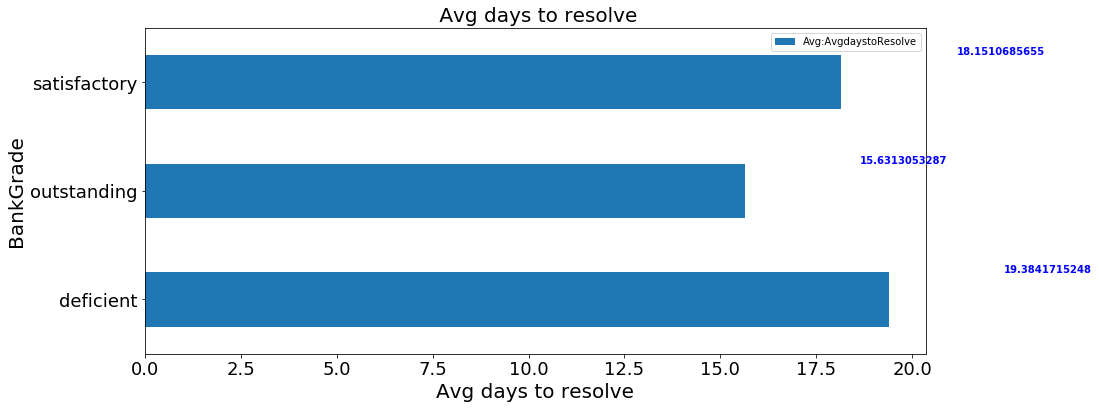

In [287]:
ax = BnkgrdAvgRes[['Avg:AvgdaystoResolve']].plot(kind='barh', title =" Avg days to resolve", figsize=(14, 6), legend=True, fontsize=18)
ax.set_xlabel("Avg days to resolve", fontsize=20)
ax.set_ylabel("BankGrade", fontsize=20)
plt.rc('axes', titlesize=20)
values=BnkgrdAvgRes["Avg:AvgdaystoResolve"].tolist()

for i, v in enumerate(values):
    ax.text(v + 3, i + .25, str(v), color='blue', fontweight='bold')
    
plt.show()

#### 2) Median days to resolve vs bank grade

In [281]:
BnkgrdMedRes = FnllBanklvldata_Tgt[['BankGrade','MediandaystoResolve']].groupby(['BankGrade'])['MediandaystoResolve'].mean().reset_index(name='Avg:MediandaystoResolve')
BnkgrdMedRes.set_index("BankGrade",drop=True,inplace=True)

In [282]:
BnkgrdMedRes

Avg:MediandaystoResolve
BankGrade                            
deficient                   14.583333
outstanding                 12.142857
satisfactory                14.055556

#### 3) % of grievance issues resolved < 1Month vs bank grade

In [283]:
BnkgrdLessMonth = FnllBanklvldata_Tgt[['BankGrade','Lessthan1Month_pct']].groupby(['BankGrade'])['Lessthan1Month_pct'].mean().reset_index(name='Avg:Lessthan1Month_pct')
BnkgrdLessMonth.set_index("BankGrade",drop=True,inplace=True)
BnkgrdLessMonth

Avg:Lessthan1Month_pct
BankGrade                           
deficient                  84.923889
outstanding                91.797857
satisfactory               86.164815

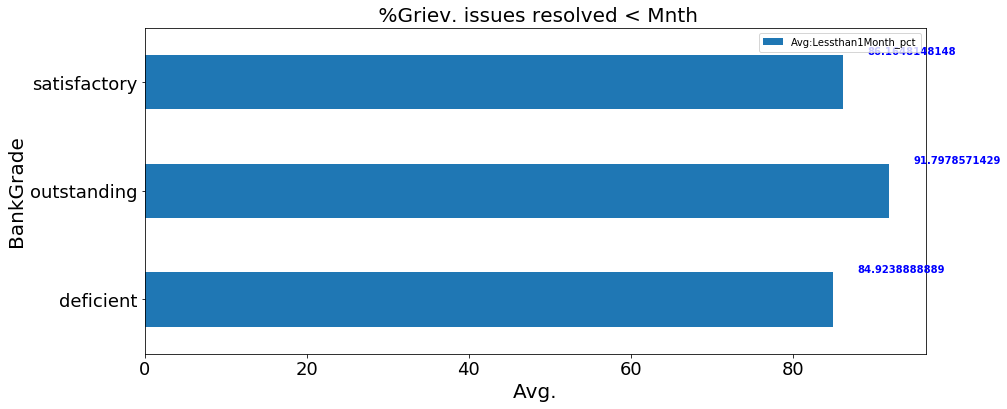

In [285]:
ax = BnkgrdLessMonth[['Avg:Lessthan1Month_pct']].plot(kind='barh', title =" %Griev. issues resolved < Mnth", figsize=(14, 6), legend=True, fontsize=18)
ax.set_xlabel("Avg.", fontsize=20)
ax.set_ylabel("BankGrade", fontsize=20)
plt.rc('axes', titlesize=20)
values=BnkgrdLessMonth["Avg:Lessthan1Month_pct"].tolist()

for i, v in enumerate(values):
    ax.text(v + 3, i + .25, str(v), color='blue', fontweight='bold')
    
plt.show()

#### 3) % of grievance issues resolved in 1-2Months vs bank grade

In [274]:
Bnkgrd1to2Month = FnllBanklvldata_Tgt[['BankGrade','onetotwoMonths_pct']].groupby(['BankGrade'])['onetotwoMonths_pct'].mean().reset_index(name='Avg:onetotwoMonths_pct')
Bnkgrd1to2Month.set_index("BankGrade",drop=True,inplace=True)
Bnkgrd1to2Month

Avg:onetotwoMonths_pct
BankGrade                           
deficient                  14.048889
outstanding                 8.065714
satisfactory               12.651667

#### 4) % of grievance issues resolved in 2-3Months vs bank grade

In [288]:
Bnkgrd2to3Month = FnllBanklvldata_Tgt[['BankGrade','twotothreeMonths_pct']].groupby(['BankGrade'])['twotothreeMonths_pct'].mean().reset_index(name='Avg:twotothreeMonths_pct')
Bnkgrd2to3Month.set_index("BankGrade",drop=True,inplace=True)
Bnkgrd2to3Month

Avg:twotothreeMonths_pct
BankGrade                             
deficient                     0.935000
outstanding                   0.110000
satisfactory                  0.965556

#### 5) % of grievance issues resolved in >3 Months vs bank grade

In [289]:
BnkgrdGt3Month = FnllBanklvldata_Tgt[['BankGrade','threeormoreMonths_pct']].groupby(['BankGrade'])['threeormoreMonths_pct'].mean().reset_index(name='Avg:threeormoreMonths_pct')
BnkgrdGt3Month.set_index("BankGrade",drop=True,inplace=True)
BnkgrdGt3Month

Avg:threeormoreMonths_pct
BankGrade                              
deficient                      0.091667
outstanding                    0.026429
satisfactory                   0.217222

#### 6) % of grievance issues in state 9 as compared to total issues of the bank vs bank grade

In [290]:
Bnkgrdst9 = FnllBanklvldata_Tgt[['BankGrade','State9_pct']].groupby(['BankGrade'])['State9_pct'].mean().reset_index(name='Avg:State9_pct')
Bnkgrdst9.set_index("BankGrade",drop=True,inplace=True)
Bnkgrdst9

Avg:State9_pct
BankGrade                   
deficient          15.106667
outstanding        11.252143
satisfactory       13.554444

#### 7) % of grievance issues in state 14 as compared to total issues of the bank vs bank grade

In [291]:
Bnkgrdst14 = FnllBanklvldata_Tgt[['BankGrade','State14_pct']].groupby(['BankGrade'])['State14_pct'].mean().reset_index(name='Avg:State14_pct')
Bnkgrdst14.set_index("BankGrade",drop=True,inplace=True)
Bnkgrdst14

Avg:State14_pct
BankGrade                    
deficient            7.948889
outstanding          9.896429
satisfactory         9.217222

#### 8) % of grievance issues in state 43 as compared to total issues of the bank vs bank grade

In [292]:
Bnkgrdst43 = FnllBanklvldata_Tgt[['BankGrade','State43_pct']].groupby(['BankGrade'])['State43_pct'].mean().reset_index(name='Avg:State43_pct')
Bnkgrdst43.set_index("BankGrade",drop=True,inplace=True)
Bnkgrdst43

Avg:State43_pct
BankGrade                    
deficient            7.361111
outstanding          2.775000
satisfactory         5.830556

#### 9) % of grievance issues in state 53 as compared to total issues of the bank vs bank grade

In [293]:
Bnkgrdst53 = FnllBanklvldata_Tgt[['BankGrade','State53_pct']].groupby(['BankGrade'])['State53_pct'].mean().reset_index(name='Avg:State53_pct')
Bnkgrdst53.set_index("BankGrade",drop=True,inplace=True)
Bnkgrdst53

Avg:State53_pct
BankGrade                    
deficient            5.974444
outstanding          7.986429
satisfactory         7.880741

#### 10) % of grievance issues in state 47 as compared to total issues of the bank vs bank grade

In [294]:
Bnkgrdst47= FnllBanklvldata_Tgt[['BankGrade','State47_pct']].groupby(['BankGrade'])['State47_pct'].mean().reset_index(name='Avg:State47_pct')
Bnkgrdst47.set_index("BankGrade",drop=True,inplace=True)
Bnkgrdst47

Avg:State47_pct
BankGrade                    
deficient            3.687778
outstanding          3.611429
satisfactory         3.651852

#### 11) % of grievance issues related to business paractices as compared to total issues of the bank vs bank grade

In [295]:
BnkgrdBP= FnllBanklvldata_Tgt[['BankGrade','BusinessPract_pct']].groupby(['BankGrade'])['BusinessPract_pct'].mean().reset_index(name='Avg:BusinessPract_pct')
BnkgrdBP.set_index("BankGrade",drop=True,inplace=True)
BnkgrdBP

Avg:BusinessPract_pct
BankGrade                          
deficient                 21.686111
outstanding               21.458571
satisfactory              22.482222

#### 12) % of grievance issues related to communication concerns  as compared to total issues of the bank vs bank grade

In [296]:
BnkgrdComm= FnllBanklvldata_Tgt[['BankGrade','Communicn_pct']].groupby(['BankGrade'])['Communicn_pct'].mean().reset_index(name='Avg:Communicn_pct')
BnkgrdComm.set_index("BankGrade",drop=True,inplace=True)
BnkgrdComm

Avg:Communicn_pct
BankGrade                      
deficient             60.296667
outstanding           62.288571
satisfactory          61.472222

#### 13) % of grievance issues related to late fee/interest charges as compared to total issues of the bank vs bank grade

In [297]:
BnkgrdLatefe= FnllBanklvldata_Tgt[['BankGrade','LateFeeIntCharg_pct']].groupby(['BankGrade'])['LateFeeIntCharg_pct'].mean().reset_index(name='Avg:LateFeeIntCharg_pct')
BnkgrdLatefe.set_index("BankGrade",drop=True,inplace=True)
BnkgrdLatefe

Avg:LateFeeIntCharg_pct
BankGrade                            
deficient                   32.044444
outstanding                 28.955714
satisfactory                29.271296

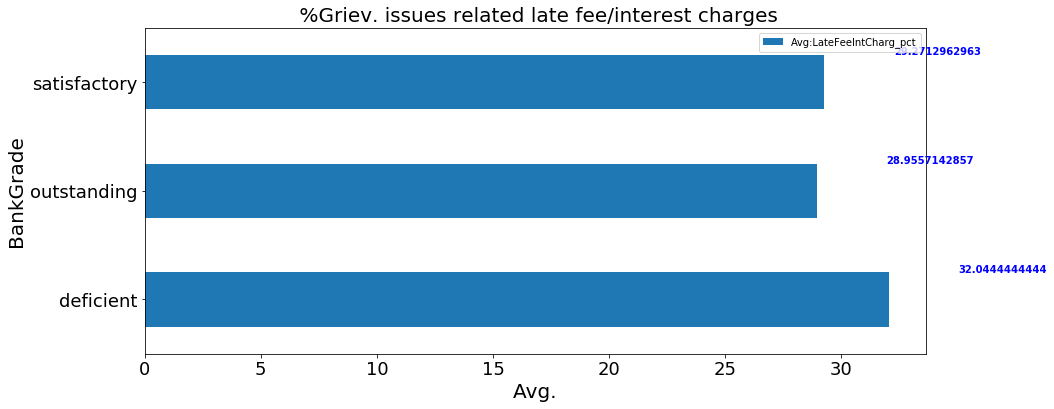

In [298]:
ax = BnkgrdLatefe[['Avg:LateFeeIntCharg_pct']].plot(kind='barh', title =" %Griev. issues related late fee/interest charges", figsize=(14, 6), legend=True, fontsize=18)
ax.set_xlabel("Avg.", fontsize=20)
ax.set_ylabel("BankGrade", fontsize=20)
plt.rc('axes', titlesize=20)
values=BnkgrdLatefe["Avg:LateFeeIntCharg_pct"].tolist()

for i, v in enumerate(values):
    ax.text(v + 3, i + .25, str(v), color='blue', fontweight='bold')
    
plt.show()

#### 14) % of grievance issues related to customer CIBIL score  as compared to total issues of the bank vs bank grade

In [299]:
BnkgrdCIBIL= FnllBanklvldata_Tgt[['BankGrade','CIBILScore_pct']].groupby(['BankGrade'])['CIBILScore_pct'].mean().reset_index(name='Avg:CIBILScore_pct')
BnkgrdCIBIL.set_index("BankGrade",drop=True,inplace=True)
BnkgrdCIBIL

Avg:CIBILScore_pct
BankGrade                       
deficient              23.304444
outstanding            20.831429
satisfactory           20.630741

#### 15) % of grievance issues related to closed and cancelled  concerns as compared to total issues of the bank vs bank grade

In [300]:
BnkgrdClsd= FnllBanklvldata_Tgt[['BankGrade','CloseCancel_pct']].groupby(['BankGrade'])['CloseCancel_pct'].mean().reset_index(name='Avg:CloseCancel_pct')
BnkgrdClsd.set_index("BankGrade",drop=True,inplace=True)
BnkgrdClsd

Avg:CloseCancel_pct
BankGrade                        
deficient               30.502222
outstanding             25.007143
satisfactory            25.261296

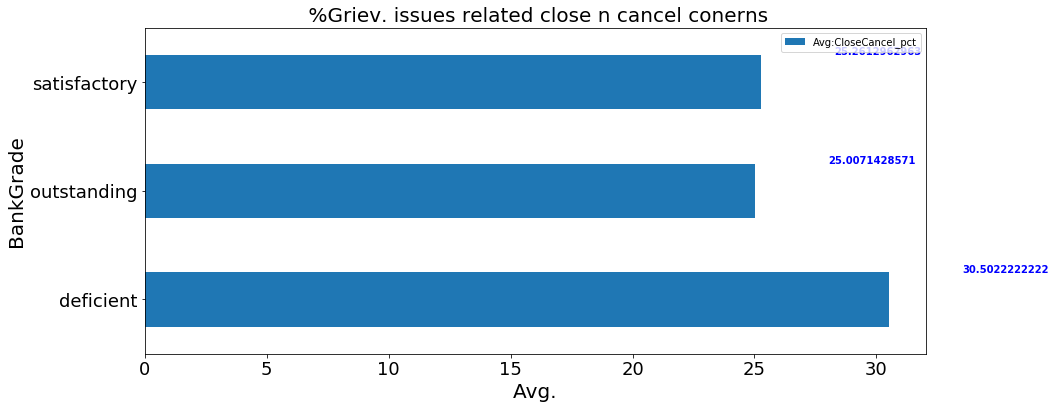

In [301]:
ax = BnkgrdClsd[['Avg:CloseCancel_pct']].plot(kind='barh', title =" %Griev. issues related close n cancel conerns", figsize=(14, 6), legend=True, fontsize=18)
ax.set_xlabel("Avg.", fontsize=20)
ax.set_ylabel("BankGrade", fontsize=20)
plt.rc('axes', titlesize=20)
values=BnkgrdClsd["Avg:CloseCancel_pct"].tolist()

for i, v in enumerate(values):
    ax.text(v + 3, i + .25, str(v), color='blue', fontweight='bold')
    
plt.show()

#### 16) % of grievance issues related to purchase concerns as compared to total issues of the bank vs bank grade

In [302]:
Bnkgrdpurch= FnllBanklvldata_Tgt[['BankGrade','purchaser_pct']].groupby(['BankGrade'])['purchaser_pct'].mean().reset_index(name='Avg:purchaser_pct')
Bnkgrdpurch.set_index("BankGrade",drop=True,inplace=True)
Bnkgrdpurch

Avg:purchaser_pct
BankGrade                      
deficient             17.256667
outstanding           16.522143
satisfactory          13.823333

#### 17) % of grievance issues related to delays and recurring concerns as compared to total issues of the bank vs bank grade

In [303]:
Bnkgrddly= FnllBanklvldata_Tgt[['BankGrade','DelayRecur_pct']].groupby(['BankGrade'])['DelayRecur_pct'].mean().reset_index(name='Avg:DelayRecur_pct')
Bnkgrddly.set_index("BankGrade",drop=True,inplace=True)
Bnkgrddly

Avg:DelayRecur_pct
BankGrade                       
deficient              69.367778
outstanding            74.632143
satisfactory           70.008333

#### 18) % of grievance issues related to legal concerns as compared to total issues of the bank vs bank grade

In [304]:
Bnklgl= FnllBanklvldata_Tgt[['BankGrade','legal_pct']].groupby(['BankGrade'])['legal_pct'].mean().reset_index(name='Avg:legal_pct')
Bnklgl.set_index("BankGrade",drop=True,inplace=True)
Bnklgl

Avg:legal_pct
BankGrade                  
deficient         41.507778
outstanding       38.360000
satisfactory      40.717593

#### 19) % of grievance issues related to marketing and offer  concerns as compared to total issues of the bank vs bank grade

In [305]:
Bnkmkt= FnllBanklvldata_Tgt[['BankGrade','MktOfferRwd_pct']].groupby(['BankGrade'])['MktOfferRwd_pct'].mean().reset_index(name='Avg:MktOfferRwd_pct')
Bnkmkt.set_index("BankGrade",drop=True,inplace=True)
Bnkmkt

Avg:MktOfferRwd_pct
BankGrade                        
deficient               25.118889
outstanding             14.052143
satisfactory            17.471852

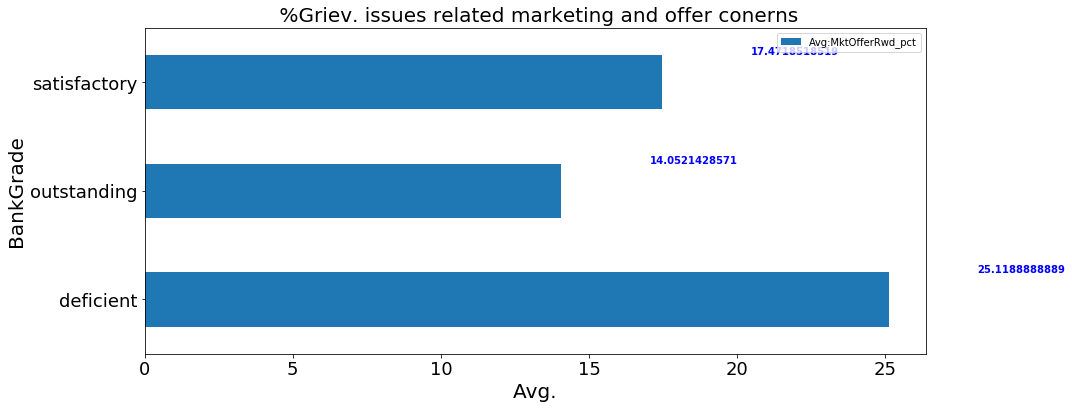

In [307]:
ax = Bnkmkt[['Avg:MktOfferRwd_pct']].plot(kind='barh', title =" %Griev. issues related marketing and offer conerns", figsize=(14, 6), legend=True, fontsize=18)
ax.set_xlabel("Avg.", fontsize=20)
ax.set_ylabel("BankGrade", fontsize=20)
plt.rc('axes', titlesize=20)
values=Bnkmkt["Avg:MktOfferRwd_pct"].tolist()

for i, v in enumerate(values):
    ax.text(v + 3, i + .25, str(v), color='blue', fontweight='bold')
    
plt.show()

#### 20) % of grievance issues related to payments concerns as compared to total issues of the bank vs bank grade

In [308]:
Bnkgrdpymnt= FnllBanklvldata_Tgt[['BankGrade','PaymentIssue_pct']].groupby(['BankGrade'])['PaymentIssue_pct'].mean().reset_index(name='Avg:PaymentIssue_pct')
Bnkgrdpymnt.set_index("BankGrade",drop=True,inplace=True)
Bnkgrdpymnt

Avg:PaymentIssue_pct
BankGrade                         
deficient                63.375000
outstanding              60.972857
satisfactory             62.418148

#### 21) % of grievance issues related to broader mortgage concerns as compared to total issues of the bank vs bank grade

In [309]:
Bnkgrdmortgbr= FnllBanklvldata_Tgt[['BankGrade','MortgageBroad_pct']].groupby(['BankGrade'])['MortgageBroad_pct'].mean().reset_index(name='Avg:MortgageBroad_pct')
Bnkgrdmortgbr.set_index("BankGrade",drop=True,inplace=True)
Bnkgrdmortgbr

Avg:MortgageBroad_pct
BankGrade                          
deficient                 30.520556
outstanding               41.500714
satisfactory              36.644259

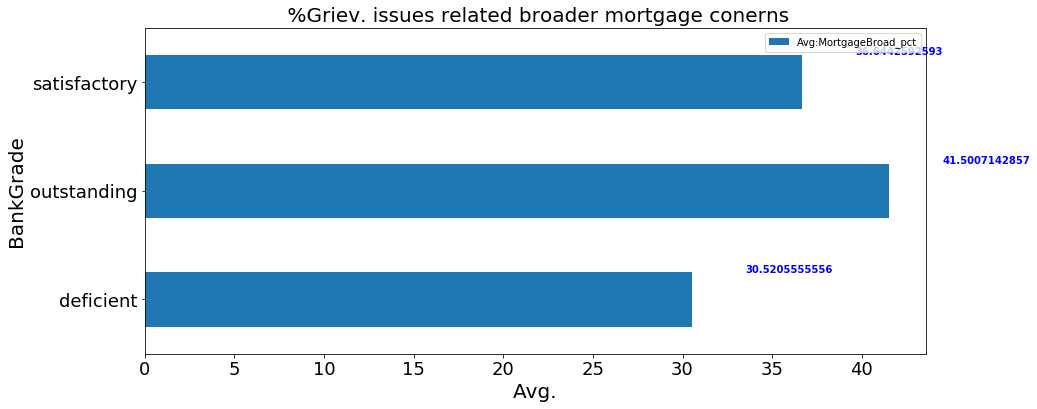

In [310]:
ax = Bnkgrdmortgbr[['Avg:MortgageBroad_pct']].plot(kind='barh', title =" %Griev. issues related broader mortgage conerns", figsize=(14, 6), legend=True, fontsize=18)
ax.set_xlabel("Avg.", fontsize=20)
ax.set_ylabel("BankGrade", fontsize=20)
plt.rc('axes', titlesize=20)
values=Bnkgrdmortgbr["Avg:MortgageBroad_pct"].tolist()

for i, v in enumerate(values):
    ax.text(v + 3, i + .25, str(v), color='blue', fontweight='bold')
    
plt.show()

#### 22) % of grievance issues related to theft and fraud concerns as compared to total issues of the bank vs bank grade

In [311]:
Bnkgrdthft= FnllBanklvldata_Tgt[['BankGrade','TeftFraudThreat_pct']].groupby(['BankGrade'])['TeftFraudThreat_pct'].mean().reset_index(name='Avg:TeftFraudThreat_pct')
Bnkgrdthft.set_index("BankGrade",drop=True,inplace=True)
Bnkgrdthft

Avg:TeftFraudThreat_pct
BankGrade                            
deficient                   17.172778
outstanding                  9.888571
satisfactory                13.496667

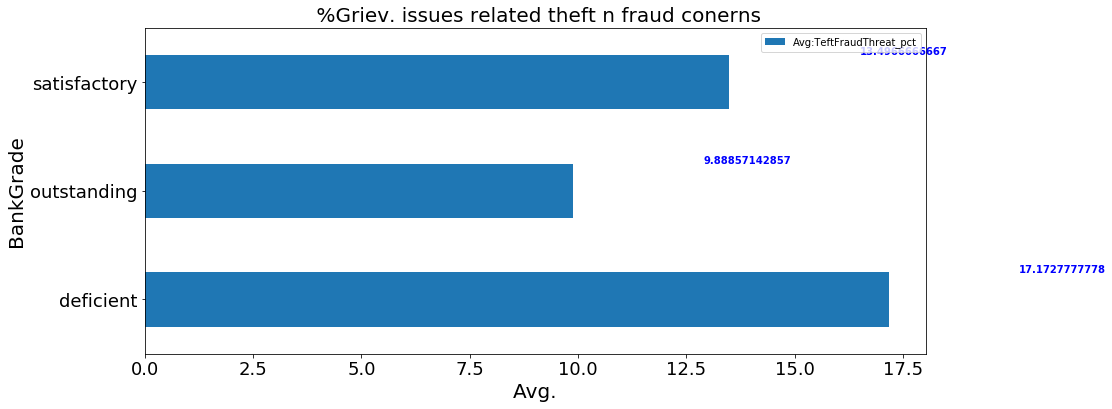

In [312]:
ax = Bnkgrdthft[['Avg:TeftFraudThreat_pct']].plot(kind='barh', title =" %Griev. issues related theft n fraud conerns", figsize=(14, 6), legend=True, fontsize=18)
ax.set_xlabel("Avg.", fontsize=20)
ax.set_ylabel("BankGrade", fontsize=20)
plt.rc('axes', titlesize=20)
values=Bnkgrdthft["Avg:TeftFraudThreat_pct"].tolist()

for i, v in enumerate(values):
    ax.text(v + 3, i + .25, str(v), color='blue', fontweight='bold')
    
plt.show()

#### 23) % of grievance issues related to mortgage  concerns as compared to total issues of the bank vs bank grade

In [313]:
Bnkgrdmtg= FnllBanklvldata_Tgt[['BankGrade','Mortgage_pct']].groupby(['BankGrade'])['Mortgage_pct'].mean().reset_index(name='Avg:Mortgage_pct')
Bnkgrdmtg.set_index("BankGrade",drop=True,inplace=True)
Bnkgrdmtg

Avg:Mortgage_pct
BankGrade                     
deficient            29.078889
outstanding          55.005714
satisfactory         37.244259

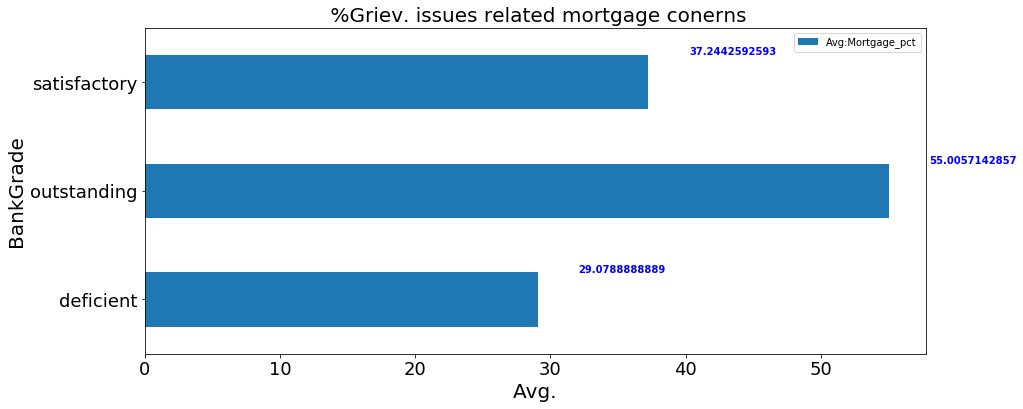

In [314]:
ax = Bnkgrdmtg[['Avg:Mortgage_pct']].plot(kind='barh', title =" %Griev. issues related mortgage conerns", figsize=(14, 6), legend=True, fontsize=18)
ax.set_xlabel("Avg.", fontsize=20)
ax.set_ylabel("BankGrade", fontsize=20)
plt.rc('axes', titlesize=20)
values=Bnkgrdmtg["Avg:Mortgage_pct"].tolist()

for i, v in enumerate(values):
    ax.text(v + 3, i + .25, str(v), color='blue', fontweight='bold')
    
plt.show()

#### 24) % of grievance issues related to credit cards concerns as compared to total issues of the bank vs bank grade

In [315]:
BnkgrdCC= FnllBanklvldata_Tgt[['BankGrade','CreditCard_pct']].groupby(['BankGrade'])['CreditCard_pct'].mean().reset_index(name='Avg:CreditCard_pct')
BnkgrdCC.set_index("BankGrade",drop=True,inplace=True)
BnkgrdCC

Avg:CreditCard_pct
BankGrade                       
deficient              50.219444
outstanding             4.687857
satisfactory           18.325000

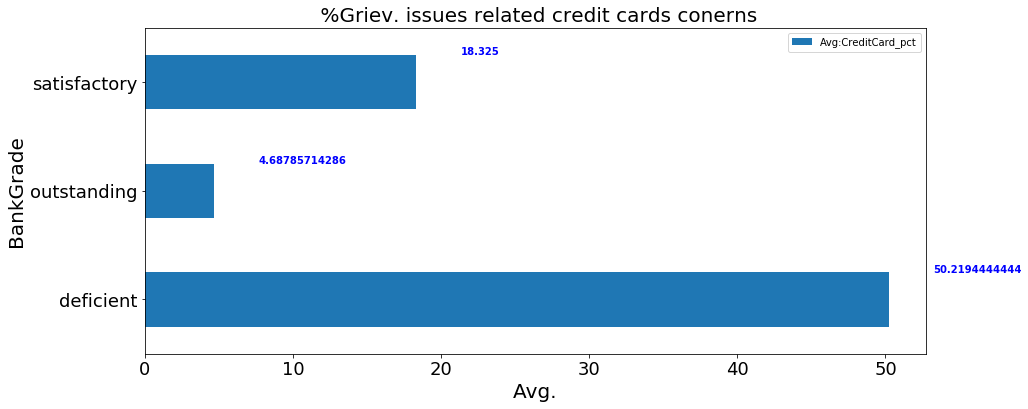

In [316]:
ax = BnkgrdCC[['Avg:CreditCard_pct']].plot(kind='barh', title =" %Griev. issues related credit cards conerns", figsize=(14, 6), legend=True, fontsize=18)
ax.set_xlabel("Avg.", fontsize=20)
ax.set_ylabel("BankGrade", fontsize=20)
plt.rc('axes', titlesize=20)
values=BnkgrdCC["Avg:CreditCard_pct"].tolist()

for i, v in enumerate(values):
    ax.text(v + 3, i + .25, str(v), color='blue', fontweight='bold')
    
plt.show()

#### 25) % of grievance issues related to closed with explanation as compared to total issues of the bank vs bank grade

In [317]:
BnkgrdClsdExp= FnllBanklvldata_Tgt[['BankGrade','ClosExpl_pct']].groupby(['BankGrade'])['ClosExpl_pct'].mean().reset_index(name='Avg:ClosExpl_pct')
BnkgrdClsdExp.set_index("BankGrade",drop=True,inplace=True)
BnkgrdClsdExp

Avg:ClosExpl_pct
BankGrade                     
deficient            81.633333
outstanding          91.666429
satisfactory         84.415185

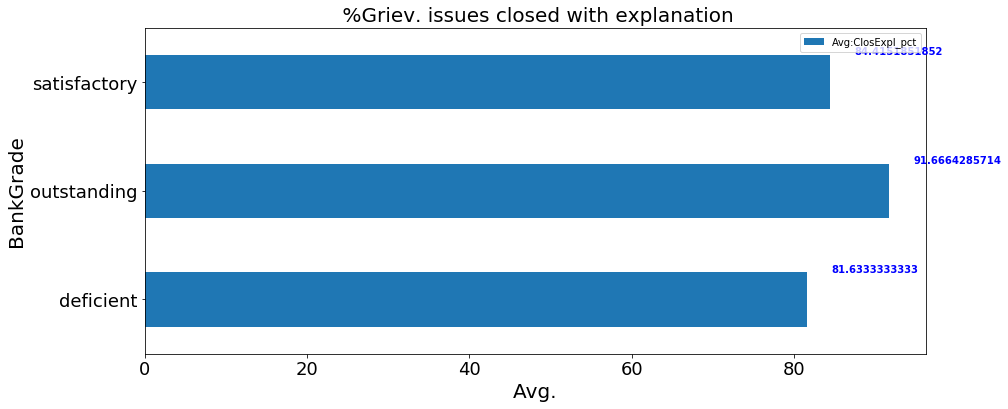

In [319]:
ax = BnkgrdClsdExp[['Avg:ClosExpl_pct']].plot(kind='barh', title =" %Griev. issues closed with explanation", figsize=(14, 6), legend=True, fontsize=18)
ax.set_xlabel("Avg.", fontsize=20)
ax.set_ylabel("BankGrade", fontsize=20)
plt.rc('axes', titlesize=20)
values=BnkgrdClsdExp["Avg:ClosExpl_pct"].tolist()

for i, v in enumerate(values):
    ax.text(v + 3, i + .25, str(v), color='blue', fontweight='bold')
    
plt.show()

#### 26) % of grievance issues related to closed with explanation an disputed as compared to total issues of the bank vs bank grade

In [318]:
BnkgrdClsdExpDisp= FnllBanklvldata_Tgt[['BankGrade','ClosExplDisp_pct']].groupby(['BankGrade'])['ClosExplDisp_pct'].mean().reset_index(name='Avg:ClosExplDisp_pct')
BnkgrdClsdExpDisp.set_index("BankGrade",drop=True,inplace=True)
BnkgrdClsdExpDisp

Avg:ClosExplDisp_pct
BankGrade                         
deficient                21.954444
outstanding              14.307143
satisfactory             19.204259

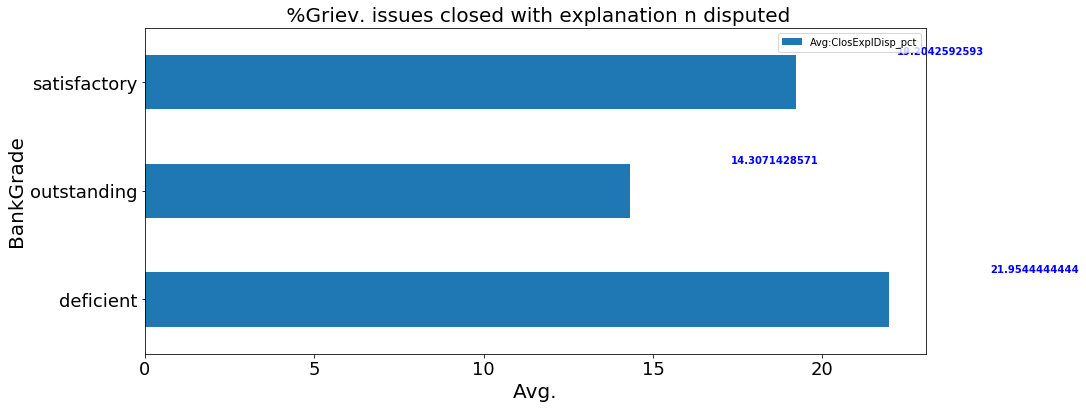

In [320]:
ax = BnkgrdClsdExpDisp[['Avg:ClosExplDisp_pct']].plot(kind='barh', title =" %Griev. issues closed with explanation n disputed", figsize=(14, 6), legend=True, fontsize=18)
ax.set_xlabel("Avg.", fontsize=20)
ax.set_ylabel("BankGrade", fontsize=20)
plt.rc('axes', titlesize=20)
values=BnkgrdClsdExpDisp["Avg:ClosExplDisp_pct"].tolist()

for i, v in enumerate(values):
    ax.text(v + 3, i + .25, str(v), color='blue', fontweight='bold')
    
plt.show()

#### 27) % of grievance issues related to closed with explanation , disputed and communication issues as compared to total issues of the bank vs bank grade

In [321]:
BnkgrdClsExpDisp= FnllBanklvldata_Tgt[['BankGrade','ClosExplDispCom_pct']].groupby(['BankGrade'])['ClosExplDispCom_pct'].mean().reset_index(name='Avg:ClosExplDispCom_pct')
BnkgrdClsExpDisp.set_index("BankGrade",drop=True,inplace=True)
BnkgrdClsExpDisp

Avg:ClosExplDispCom_pct
BankGrade                            
deficient                   13.770000
outstanding                  9.895714
satisfactory                12.586667

#### 28) % of grievance issues related to closed and cancelled  concerns as compared to total issues of the bank vs bank grade

In [322]:
Bnkgrdpmnt= FnllBanklvldata_Tgt[['BankGrade','Payments_pct']].groupby(['BankGrade'])['Payments_pct'].mean().reset_index(name='Avg:Payments_pct')
Bnkgrdpmnt.set_index("BankGrade",drop=True,inplace=True)
Bnkgrdpmnt

Avg:Payments_pct
BankGrade                     
deficient            24.587222
outstanding          34.722857
satisfactory         31.129815

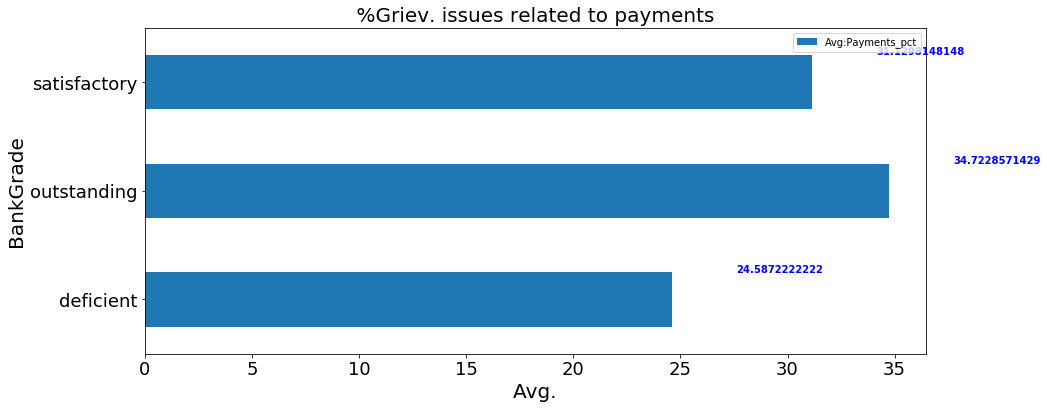

In [323]:
ax = Bnkgrdpmnt[['Avg:Payments_pct']].plot(kind='barh', title =" %Griev. issues related to payments ", figsize=(14, 6), legend=True, fontsize=18)
ax.set_xlabel("Avg.", fontsize=20)
ax.set_ylabel("BankGrade", fontsize=20)
plt.rc('axes', titlesize=20)
values=Bnkgrdpmnt["Avg:Payments_pct"].tolist()

for i, v in enumerate(values):
    ax.text(v + 3, i + .25, str(v), color='blue', fontweight='bold')
    
plt.show()

#### 29) % of grievance issues related to UFDP  concerns as compared to total issues of the bank vs bank grade

In [324]:
BnkgrdUFDP= FnllBanklvldata_Tgt[['BankGrade','UFDP_pct']].groupby(['BankGrade'])['UFDP_pct'].mean().reset_index(name='Avg:UFDP_pct')
BnkgrdUFDP.set_index("BankGrade",drop=True,inplace=True)
BnkgrdUFDP

Avg:UFDP_pct
BankGrade                 
deficient        62.031667
outstanding      53.432143
satisfactory     58.035926

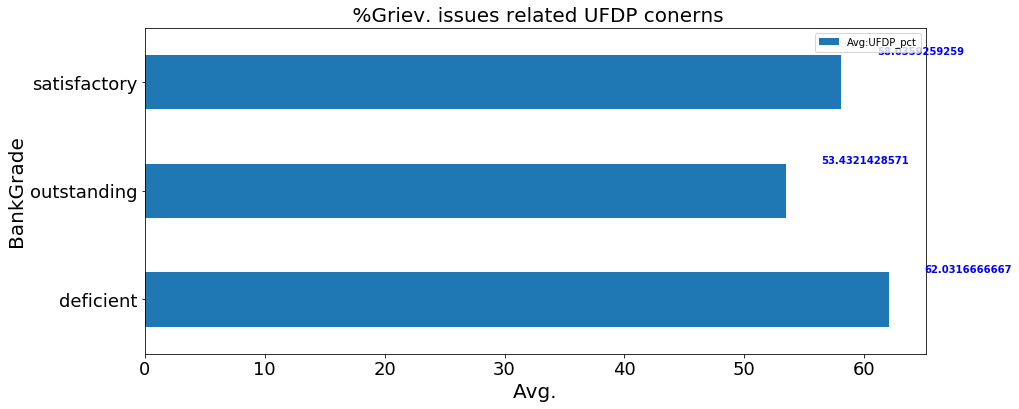

In [325]:
ax = BnkgrdUFDP[['Avg:UFDP_pct']].plot(kind='barh', title =" %Griev. issues related UFDP conerns", figsize=(14, 6), legend=True, fontsize=18)
ax.set_xlabel("Avg.", fontsize=20)
ax.set_ylabel("BankGrade", fontsize=20)
plt.rc('axes', titlesize=20)
values=BnkgrdUFDP["Avg:UFDP_pct"].tolist()

for i, v in enumerate(values):
    ax.text(v + 3, i + .25, str(v), color='blue', fontweight='bold')
    
plt.show()

#### The Avg % of UFDP issues are more in deficient followed by satisfactory and outstanding grades

# Distribution of all important features -> Shape and Outliers

/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2878: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


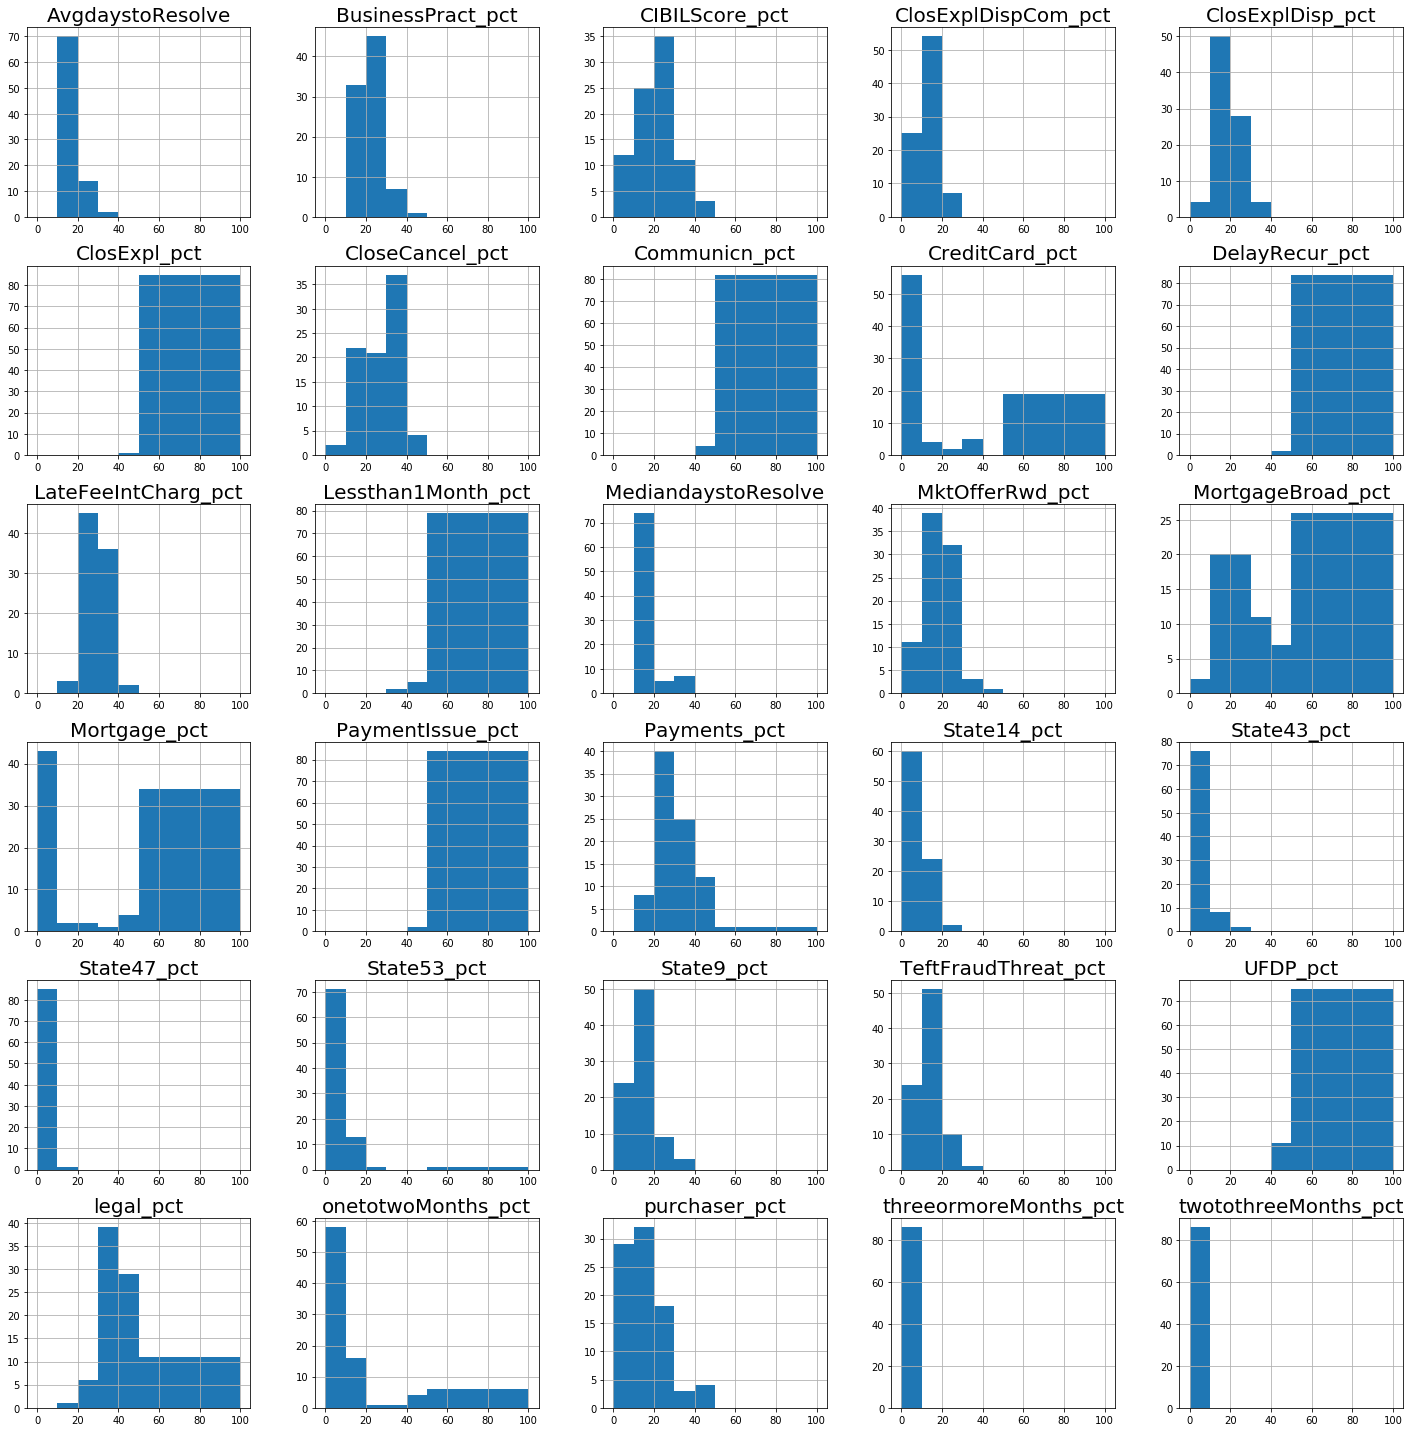

In [33]:
fig = plt.figure(figsize = (20,20))
ax = fig.gca()
FnllBanklvldata_Tgt.hist(ax = ax, bins=[0, 10, 20, 30, 40, 50, 100])

plt.tight_layout()
plt.show()

# Corrlation between important features - > Multicollinearity check (Correlation plot)

In [326]:
import seaborn as sns

In [331]:
correlation = FnllBanklvldata_Tgt.corr()
correlation.to_csv('TrainBank_Corr.csv')

In [335]:
corr = FnllBanklvldata_Tgt.corr()
corr.style.background_gradient()

In [482]:
#FnllBanklvldata_Tgt.columns

## Feature selection/correlation with Target

In [3]:
#Import the saved train data
FnllBanklvldata_Tgt = pd.read_pickle('FnllBanklvldata_Tgt_Saved.pkl')

In [4]:
dropc = ['ClosExpl_pct','ClosExplDispCom_pct','MortgageBroad_pct','MediandaystoResolve','Lessthan1Month_pct','onetotwoMonths_pct','BankID','State53_pct','twotothreeMonths_pct','State14_pct','Communicn_pct','purchaser_pct','State47_pct','threeormoreMonths_pct']
Modeldata=FnllBanklvldata_Tgt.drop(dropc, axis=1)

In [5]:
#Sepatate Target and features
#X=Modeldata.loc[:,['ClosExplDisp_pct','TeftFraudThreat_pct']]

X = Modeldata.drop('BankGrade', axis=1)
y = Modeldata.loc[:,'BankGrade']

In [6]:
#Recursive Feature Elimination
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial')

rfe = RFE(logreg, 1)
rfe = rfe.fit(X, y.values.ravel())

rfe_support=pd.DataFrame((rfe.support_).tolist())
rfe_rank=pd.DataFrame((rfe.ranking_).tolist())

In [7]:
# Feature Importance
from sklearn import datasets
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier
# fit an Extra Trees model to the data
model = ExtraTreesClassifier()
model.fit(X, y)
# display the relative importance of each attribute
print(model.feature_importances_)
EXC_FeatureImp=pd.DataFrame(model.feature_importances_)

[0.12148144 0.02696513 0.05040109 0.04745521 0.04866456 0.06129301
 0.03665636 0.06603687 0.05966519 0.08613255 0.05686408 0.05191687
 0.03772919 0.0651044  0.10885527 0.04313841 0.03164036]


/anaconda2/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [8]:
Featuresdf=pd.DataFrame(X.columns.tolist())
frames=[rfe_support,rfe_rank,Featuresdf,EXC_FeatureImp]
ImpFeatures = pd.concat(frames,axis=1)
ImpFeatures.to_csv('ImpFeatures.csv')

In [10]:
#Correlatoion between independent variables
import seaborn as sns
correlation = Modeldata.corr()
correlation.to_csv('TrainBank_Corr.csv')

## Variable selection using logistic regression

In [3]:
#Import the saved train data
FnllBanklvldata_Tgt = pd.read_pickle('FnllBanklvldata_Tgt_Saved.pkl')

In [5]:
FnllBanklvldata_Tgt.columns

Index([u'BankID', u'AvgdaystoResolve', u'MediandaystoResolve', u'BankGrade',
       u'State9_pct', u'State14_pct', u'State43_pct', u'State53_pct',
       u'State47_pct', u'BusinessPract_pct', u'Communicn_pct',
       u'LateFeeIntCharg_pct', u'CIBILScore_pct', u'CloseCancel_pct',
       u'purchaser_pct', u'DelayRecur_pct', u'legal_pct', u'MktOfferRwd_pct',
       u'PaymentIssue_pct', u'MortgageBroad_pct', u'TeftFraudThreat_pct',
       u'Mortgage_pct', u'CreditCard_pct', u'Lessthan1Month_pct',
       u'onetotwoMonths_pct', u'twotothreeMonths_pct',
       u'threeormoreMonths_pct', u'ClosExpl_pct', u'ClosExplDisp_pct',
       u'ClosExplDispCom_pct', u'Payments_pct', u'UFDP_pct'],
      dtype='object')

In [15]:

from patsy import dmatrices
#y,X = dmatrices('BankGrade ~AvgdaystoResolve+State43_pct+LateFeeIntCharg_pct+MktOfferRwd_pct+ClosExplDisp_pct', data=Modeldata, return_type='dataframe')

In [69]:

from patsy import dmatrices
y,X = dmatrices('BankGrade ~UFDP_pct', data=FnllBanklvldata_Tgt, return_type='dataframe')

In [70]:
import statsmodels.api as sm
classifier = sm.MNLogit(y, X)  
result = classifier.fit() 
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.841936
         Iterations 6
                          MNLogit Regression Results                          
Dep. Variable:                      y   No. Observations:                   86
Model:                        MNLogit   Df Residuals:                       82
Method:                           MLE   Df Model:                            2
Date:                Wed, 28 Nov 2018   Pseudo R-squ.:                 0.07991
Time:                        22:03:55   Log-Likelihood:                -72.407
converged:                       True   LL-Null:                       -78.695
                                        LLR p-value:                  0.001857
 y=BankGrade[outstanding]       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    11.2930      3.620      3.119      0.002       4.